In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from ipynb.fs.full.Funciones_basicas import *
from ipynb.fs.full.Algoritmos import *
from ipynb.fs.full.Visualizaciones import *

In [4]:
path = '../data/graph_geom_corrected_cycles.csv'
csv_grafo = pd.read_csv(path, sep=';')

geometry = gpd.read_file(path, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")

path_pesos = '../data/pesos_tapas.csv'
pesos = pd.read_csv(path_pesos)

out = {1003950, 15004, 15131, 1003744, 15190, 1003746, 13730, 1003167, 13731, 13732, 13733, 14062, 1003206, 16503, 13735, 16094, 16095}

S = set()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        S.add(origin)
        S.add(dest)

S = list(S)
id_ = {}; _id = {}; N = 0
for u in S:
    id_[u] = N; _id[N] = u
    N += 1

G = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        G.add_edge(id_[origin], id_[dest])
        
path = '../data/corrected_dijkstra.csv'
csv_grafo = pd.read_csv(path, sep=',')

T = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        T.add_edge(id_[origin], id_[dest])

W = [0] * N

for u in range(N):
    if pesos[pesos['ID_tapa'] == _id[u]].shape[0] >= 1:  ## tomamos primera columna con el id, si no hay peso = 0
        W[u] = pesos[pesos['ID_tapa'] == _id[u]].iloc[0]['per_predio']

In [5]:
mx = 0; root = None
for u in range(N):
    if get_size(G, [0] * N, u) > mx:
        mx = get_size(G, [0] * N, u)
        root = u
        
print(root, get_size(G, [0] * N, root), N)

744 4586 4586


In [6]:
def visit_robust(G, V, root, u):
    
    N = len(V)
    I = get_ideal_robust(G, V, root, u)
    
    VI = [0] * N
    for u in I:
        VI[u] = 1
    
    return [bool(VI[u] + V[u]) for u in range(N)], sum([(VI[u] and not V[u]) for u in range(N)])

def get_size_precalc_robust(G, W, V_, root, u):
    
    I = set(get_ideal_robust(G, V_, root, u))
    
    if V_[u]:
        return 0
    
    if W[u] <= 200:
        return 1
    
    V = V_.copy()
    
    s = 1; V[u] = 1
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v] and v in I:
                s += 1; V[v] = 1
                if W[v] > 200:
                    Q.append(v)
                    I.remove(v)
    
    return s

def greedyAppReduceDynamicRobust(G, W, V_, root, K, limit, wlim):
    
    V = V_.copy(); N = len(V)
    E = {u for u in range(N) if not V[u]}

    ans = []; tot = 0
    while len(ans) < K:
        
        S = [0 for u in range(N)]
        for v in E:
            _, S[v] = get_size_weight_robust(G, W, V, root, v)
        
        maxv = 0; u = -1
        for v in E:
            s = get_size_precalc_robust(G, S, V, root, v)
            if s > maxv and s <= limit and S[v] <= wlim:
                u = v
                maxv = s
        if u == -1:
            break
        
        V, x = visit_robust(G, V, root, u)
        ans.append(u); tot += x
        E.remove(u)
        
    return ans, tot

In [7]:
def plot_sample_no_intersections(G, V_, sample, geom, _id):
    
    geometry = geom.copy(); N = len(V_)
    
    V = V_.copy()
    
    I = []; C = [-1 * V[u] for u in range(N)]
    for u in sample:
        I.append(get_ideal(G, V, u))
        V, _ = visit(G, V, u)
    
    for i in range(len(I)):
        for u in I[i]:
            C[u] = i + 1

    # Marcamos los elementos visitados en geometry
    geometry['color'] = -1
    for u in range(N):
        geometry.loc[geometry['self'] == str(_id[u]) , 'color'] = C[u]
            
    # Graficamos puntos de testeo
    coord = points_coordinates(sample, geometry, _id)
    for i in range(len(coord)):
        geometry.loc[geometry.shape[0] + i] = ['a'] + ["b"] + [3] + [1] + [coord[i]] + [len(sample) - 2]
          
    # Graficamos
    f, ax = plt.subplots(figsize=(15, 15))
    ax.set_title("Resultados de testeo", fontsize=25)
    ax = geometry.plot(ax = ax, column = 'color',
                       figsize=(15, 15),
                       legend = True,
                       legend_kwds={'label': "-1: No considerado \n 0: No cubierto ", 'orientation': "horizontal"},
                       cmap = 'nipy_spectral',)
    plt.show()

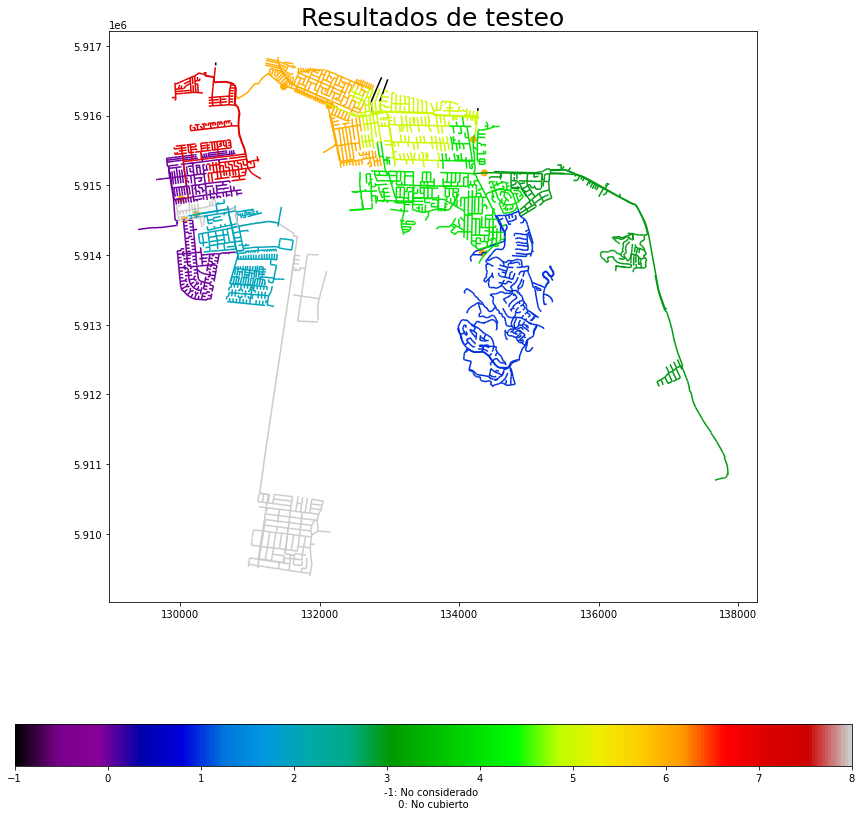

In [8]:
# low = 0; high = N
# while low != high:
#     mid = (low + high) // 2
#     P, sP = greedyAppReduceDynamic(G, W, [0] * N, 8, mid, 1e8)
#     if N - sP < mid:
#         high = mid
#     else:
#         low = mid + 1
        
low = 362
init_P, _ = greedyAppReduceDynamic(G, W, [0] * N, 8, low - 1, 1e8)

plot_sample_no_intersections(G, [0] * N, init_P, geometry, _id)

In [7]:
def simulate_robust(G, W, k2, S, verbose):
    
    iters = []; N = len(W)

    for r in S:

        if verbose:
            print(r)

        CV = [0 for u in range(N)]

        CV[r] = 1
        Q = deque([]); Q.append(r)
        while Q:
            u = Q.popleft()
            for v in G.successors(u):
                if not CV[v]:
                    CV[v] = 1
                    Q.append(v)

        V = [0] * N

        R = N
        for t in range(100):
            
            R = N - sum(V); P = []; sP = 0
            
            if verbose:
                print("it,", t, R)
            
            if t == 0:
                P = init_P
            elif R >= 10:
                low = 0; high = R
                while low != high:
                    mid = (low + high) // 2
                    P, sP = greedyAppReduceDynamicRobust(G, W, V, root, k2, mid, 1e8)
                    if R - sP < mid:
                        high = mid
                    else:
                        low = mid + 1
                P, sP = greedyAppReduceDynamicRobust(G, W, V, root, k2, low, 1e8)
                
                if low > 1:
                    P_, sP_ = greedyAppReduceDynamicRobust(G, W, V, root, k2, low - 1, 1e8)
                    
                    if verbose:
                        print("low:", low, R - sP, R - sP_)
                    
                    if abs((R - sP_) - (low - 1)) < abs((R - sP) - low) or (len(P) == 1 and sP == R):
                        P = P_; sP = sP_
            else:
                P, sP = greedyAppReduceDynamicRobust(G, W, V, root, k2, 1, 1e8)
    
            if verbose:
                plot_sample_no_intersections(G, V, P, geometry, _id)
                print("nx", len(P), sum([CV[u] for u in P]), N - sum(V))

            if sum([CV[u] for u in P]):
                V_ = [-1 * V[u] for u in range(N)]
                for u in P:
                    if CV[u]:
                        I = get_ideal(G, V, u)
                        for v in I:
                            V_[v] += 1

                V = [(V_[u] != sum([CV[u] for u in P])) for u in range(N)]
                
                if verbose:
                    print("if: ", N - sum(V))
            
            for u in P:
                if not CV[u]:
                    I = get_ideal_robust(G, V, root, u)
                    for v in I:
                        V[v] = 1
                        
            size = N - sum(V)
            weight = sum([W[u] for u in range(N) if not V[u]])
            
            if verbose:
                print(size, weight)

            if size == 1 or weight <= 200:
                iters.append(t + 1)
                print(f"Result {r}: {iters[-1]}    acc: {sum(iters) / len(iters)}")
                break
            if t == 99:
                iters.append(100)
                print(f"Result {r}: {iters[-1]}    acc: {sum(iters) / len(iters)}")

    print(sum(iters) / len(iters), max(iters))
    
    return iters

In [66]:
iters = simulate_robust(G, W, 5, random.sample(range(N), 50), False)
# simulate_robust(G, W, 5, [510], True)

Result 2347: 3    acc: 3.0
Result 3811: 4    acc: 3.5
Result 1379: 5    acc: 4.0
Result 1862: 5    acc: 4.25
Result 2805: 5    acc: 4.4
Result 52: 6    acc: 4.666666666666667
Result 1233: 5    acc: 4.714285714285714
Result 1787: 5    acc: 4.75
Result 3273: 5    acc: 4.777777777777778
Result 1592: 4    acc: 4.7
Result 3374: 10    acc: 5.181818181818182
Result 369: 5    acc: 5.166666666666667
Result 3161: 5    acc: 5.153846153846154
Result 3796: 4    acc: 5.071428571428571
Result 4153: 4    acc: 5.0
Result 2646: 4    acc: 4.9375
Result 1087: 4    acc: 4.882352941176471
Result 1641: 3    acc: 4.777777777777778
Result 1044: 4    acc: 4.7368421052631575
Result 1210: 4    acc: 4.7
Result 4430: 5    acc: 4.714285714285714
Result 3936: 6    acc: 4.7727272727272725
Result 2704: 6    acc: 4.826086956521739
Result 152: 5    acc: 4.833333333333333
Result 1330: 4    acc: 4.8
Result 3530: 4    acc: 4.769230769230769
Result 796: 5    acc: 4.777777777777778
Result 1789: 6    acc: 4.821428571428571
Res

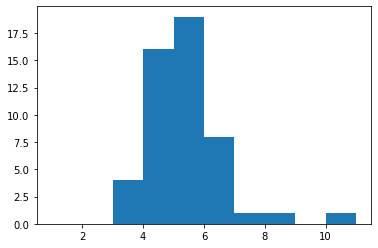

In [67]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

In [18]:
def greedyAppReduceDynamicRobustFilter(G, W, V_, root, K, limit, wlim, plim):
    
    V = V_.copy(); N = len(V)

    ans = []; tot = 0
    while len(ans) < K:
        
        E_ = []
        
        S = [0 for u in range(N)]
        for v in range(N):
            if not V[v]:
                s = get_size(G, V, v)
                sr, S[v] = get_size_weight_robust(G, W, V, root, v)
                if (sr / s) >= plim:
                    E_.append(v)
        
        maxv = 0; u = -1
        for v in E_:
            s = get_size_precalc_robust(G, S, V, root, v)
            if s > maxv and s <= limit and S[v] <= wlim:
                u = v
                maxv = s
        if u == -1:
            
            maxv = 0; u = -1
            for v in range(N):
                if not V[v]:
                    s = get_size_precalc_robust(G, S, V, root, v)
                    if s > maxv and s <= limit and S[v] <= wlim:
                        u = v
                        maxv = s
            
            if u == -1:
                break
        
        V, x = visit_robust(G, V, root, u)
        ans.append(u); tot += x
        
    return ans, tot

In [93]:
def simulate_robust_filter(G, W, k2, S, plim, verbose):
    
    map_prev = {}
    
    iters = []; N = len(W)

    for r in S:

        if verbose:
            print(r)

        CV = [0 for u in range(N)]

        CV[r] = 1
        Q = deque([]); Q.append(r)
        while Q:
            u = Q.popleft()
            for v in G.successors(u):
                if not CV[v]:
                    CV[v] = 1
                    Q.append(v)

        V = [0] * N

        R = N
        for t in range(100):
            
            R = N - sum(V); P = []; sP = 0
            
            print("                                                           ", end="\r")
            print(f"Search {r}: {t + 1}    now: {R}", end="\r")
            
            if verbose:
                print("it,", t, R)
                
            nn = 0
            for i in range(N):
                if V[i]:
                    nn += 2**i
            
            if t == 0:
                P = init_P
            elif nn in map_prev.keys():
                P = map_prev[nn]
            else:
                if R >= 10:
                    low = 0; high = R
                    while low != high:
                        mid = (low + high) // 2
                        P, sP = greedyAppReduceDynamicRobustFilter(G, W, V, root, k2, mid, 1e8, plim)
                        if R - sP < mid:
                            high = mid
                        else:
                            low = mid + 1
                    P, sP = greedyAppReduceDynamicRobustFilter(G, W, V, root, k2, low, 1e8, plim)

                    if low > 1:
                        P_, sP_ = greedyAppReduceDynamicRobustFilter(G, W, V, root, k2, low - 1, 1e8, plim)

                        if verbose:
                            print("low:", low, R - sP, R - sP_)

                        if abs((R - sP_) - (low - 1)) < abs((R - sP) - low) or (len(P) == 1 and sP == R):
                            P = P_; sP = sP_
                else:
                    P, sP = greedyAppReduceDynamicRobustFilter(G, W, V, root, k2, 1, 1e8, plim)

                map_prev[nn] = P
    
            if verbose:
                plot_sample_no_intersections(G, V, P, geometry, _id)
                print("nx", len(P), sum([CV[u] for u in P]), N - sum(V))

            if sum([CV[u] for u in P]):
                V_ = [-1 * V[u] for u in range(N)]
                for u in P:
                    if CV[u]:
                        I = get_ideal(G, V, u)
                        for v in I:
                            V_[v] += 1

                V = [(V_[u] != sum([CV[u] for u in P])) for u in range(N)]
                
                if verbose:
                    print("if: ", N - sum(V))
            
            for u in P:
                if not CV[u]:
                    I = get_ideal_robust(G, V, root, u)
                    for v in I:
                        V[v] = 1
                        
            size = N - sum(V)
            weight = sum([W[u] for u in range(N) if not V[u]])
            
            if verbose:
                print(size, weight)

            if size == 1 or weight <= 200:
                iters.append(t + 1)
                print(f"Result {r}: {iters[-1]}    acc: {sum(iters) / len(iters)}")
                break
            if t == 99:
                iters.append(100)
                print(f"Result {r}: {iters[-1]}    acc: {sum(iters) / len(iters)}")

    print(sum(iters) / len(iters), max(iters))
    
    return iters

In [111]:
iters = simulate_robust_filter(G, W, 5, range(N), 0, False)

Result 0: 5    acc: 5.0                                    
Result 1: 5    acc: 5.0                                    
Result 2: 4    acc: 4.666666666666667                      
Result 3: 4    acc: 4.5                                    
Result 4: 5    acc: 4.6                                    
Result 5: 5    acc: 4.666666666666667                      
Result 6: 5    acc: 4.714285714285714                      
Result 7: 5    acc: 4.75                                   
Result 8: 5    acc: 4.777777777777778                      
Result 9: 5    acc: 4.8                                    
Result 10: 5    acc: 4.818181818181818                     
Result 11: 5    acc: 4.833333333333333                     
Result 12: 5    acc: 4.846153846153846                     
Result 13: 5    acc: 4.857142857142857                     
Result 14: 5    acc: 4.866666666666666                     
Result 15: 5    acc: 4.875                                 
Result 16: 4    acc: 4.823529411764706  

Result 273: 4    acc: 4.978102189781022                    
Result 274: 4    acc: 4.974545454545455                    
Result 275: 9    acc: 4.989130434782608                    
Result 276: 10    acc: 5.007220216606498                   
Result 277: 10    acc: 5.025179856115108                   
Result 278: 4    acc: 5.021505376344086                    
Result 279: 5    acc: 5.021428571428571                    
Result 280: 4    acc: 5.01779359430605                     
Result 281: 7    acc: 5.024822695035461                    
Result 282: 4    acc: 5.021201413427562                    
Result 283: 6    acc: 5.024647887323944                    
Result 284: 4    acc: 5.021052631578947                    
Result 285: 5    acc: 5.020979020979021                    
Result 286: 6    acc: 5.024390243902439                    
Result 287: 5    acc: 5.024305555555555                    
Result 288: 6    acc: 5.027681660899654                    
Result 289: 6    acc: 5.031034482758621 

Result 410: 3    acc: 5.092457420924574                    
Result 411: 3    acc: 5.087378640776699                    
Result 412: 5    acc: 5.087167070217918                    
Result 413: 6    acc: 5.0893719806763285                   
Result 414: 4    acc: 5.086746987951807                    
Result 415: 5    acc: 5.086538461538462                    
Result 416: 4    acc: 5.083932853717027                    
Result 417: 4    acc: 5.08133971291866                     
Result 418: 10    acc: 5.093078758949881                   
Result 419: 4    acc: 5.09047619047619                     
Result 420: 5    acc: 5.090261282660332                    
Result 421: 4    acc: 5.087677725118484                    
Result 422: 3    acc: 5.08274231678487                     
Result 423: 5    acc: 5.0825471698113205                   
Result 424: 6    acc: 5.084705882352941                    
Result 425: 5    acc: 5.084507042253521                    
Result 426: 4    acc: 5.081967213114754 

Result 548: 5    acc: 5.114754098360656                    
Result 549: 5    acc: 5.114545454545454                    
Result 550: 5    acc: 5.114337568058076                    
Result 551: 5    acc: 5.114130434782608                    
Result 552: 5    acc: 5.113924050632911                    
Result 553: 5    acc: 5.113718411552346                    
Result 554: 5    acc: 5.113513513513514                    
Result 555: 5    acc: 5.113309352517986                    
Result 556: 5    acc: 5.11310592459605                     
Result 557: 5    acc: 5.112903225806452                    
Result 558: 5    acc: 5.112701252236136                    
Result 559: 5    acc: 5.1125                               
Result 560: 5    acc: 5.112299465240642                    
Result 561: 5    acc: 5.112099644128114                    
Result 562: 5    acc: 5.11190053285968                     
Result 563: 4    acc: 5.109929078014185                    
Result 564: 5    acc: 5.109734513274336 

Result 686: 4    acc: 5.029112081513828                    
Result 687: 5    acc: 5.02906976744186                     
Result 688: 4    acc: 5.027576197387518                    
Result 689: 5    acc: 5.027536231884058                    
Result 690: 5    acc: 5.027496382054993                    
Result 691: 5    acc: 5.027456647398844                    
Result 692: 5    acc: 5.027417027417028                    
Result 693: 5    acc: 5.027377521613833                    
Result 694: 5    acc: 5.027338129496403                    
Result 695: 5    acc: 5.027298850574713                    
Result 696: 4    acc: 5.025824964131994                    
Result 697: 5    acc: 5.025787965616046                    
Result 698: 7    acc: 5.028612303290415                    
Result 699: 4    acc: 5.027142857142858                    
Result 700: 4    acc: 5.025677603423681                    
Result 701: 4    acc: 5.024216524216524                    
Result 702: 4    acc: 5.02275960170697  

Result 823: 4    acc: 5.023058252427185                    
Result 824: 4    acc: 5.0218181818181815                   
Result 825: 5    acc: 5.021791767554479                    
Result 826: 5    acc: 5.021765417170496                    
Result 827: 5    acc: 5.021739130434782                    
Result 828: 4    acc: 5.020506634499397                    
Result 829: 6    acc: 5.021686746987951                    
Result 830: 4    acc: 5.020457280385078                    
Result 831: 4    acc: 5.019230769230769                    
Result 832: 4    acc: 5.018007202881153                    
Result 833: 4    acc: 5.016786570743405                    
Result 834: 4    acc: 5.015568862275449                    
Result 835: 4    acc: 5.014354066985646                    
Result 836: 4    acc: 5.013142174432497                    
Result 837: 4    acc: 5.011933174224343                    
Result 838: 4    acc: 5.01072705601907                     
Result 839: 4    acc: 5.0095238095238095

Result 962: 4    acc: 4.959501557632398                    
Result 963: 4    acc: 4.95850622406639                     
Result 964: 4    acc: 4.957512953367876                    
Result 965: 4    acc: 4.956521739130435                    
Result 966: 4    acc: 4.955532574974147                    
Result 967: 4    acc: 4.954545454545454                    
Result 968: 4    acc: 4.953560371517028                    
Result 969: 5    acc: 4.953608247422681                    
Result 970: 4    acc: 4.952626158599382                    
Result 971: 4    acc: 4.95164609053498                     
Result 972: 6    acc: 4.9527235354573484                   
Result 973: 6    acc: 4.953798767967146                    
Result 974: 6    acc: 4.954871794871795                    
Result 975: 6    acc: 4.95594262295082                     
Result 976: 4    acc: 4.95496417604913                     
Result 977: 5    acc: 4.955010224948875                    
Result 978: 5    acc: 4.955056179775281 

Result 1099: 4    acc: 4.933636363636364                   
Result 1100: 4    acc: 4.932788374205268                   
Result 1101: 7    acc: 4.9346642468239565                  
Result 1102: 3    acc: 4.932910244786945                   
Result 1103: 8    acc: 4.9356884057971016                  
Result 1104: 8    acc: 4.938461538461539                   
Result 1105: 4    acc: 4.937613019891501                   
Result 1106: 4    acc: 4.93676603432701                    
Result 1107: 5    acc: 4.936823104693141                   
Result 1108: 5    acc: 4.93688007213706                    
Result 1109: 4    acc: 4.936036036036036                   
Result 1110: 4    acc: 4.935193519351936                   
Result 1111: 4    acc: 4.934352517985611                   
Result 1112: 6    acc: 4.935309973045822                   
Result 1113: 4    acc: 4.934470377019749                   
Result 1114: 4    acc: 4.933632286995516                   
Result 1115: 4    acc: 4.932795698924731

Result 1236: 5    acc: 4.894907033144705                   
Result 1237: 5    acc: 4.894991922455573                   
Result 1238: 5    acc: 4.895076674737692                   
Result 1239: 6    acc: 4.8959677419354835                  
Result 1240: 5    acc: 4.896051571313457                   
Result 1241: 5    acc: 4.896135265700483                   
Result 1242: 4    acc: 4.8954143201930815                  
Result 1243: 4    acc: 4.894694533762058                   
Result 1244: 5    acc: 4.894779116465863                   
Result 1245: 4    acc: 4.89406099518459                    
Result 1246: 4    acc: 4.893344025661587                   
Result 1247: 4    acc: 4.892628205128205                   
Result 1248: 5    acc: 4.89271417133707                    
Result 1249: 5    acc: 4.8928                              
Result 1250: 5    acc: 4.892885691446843                   
Result 1251: 5    acc: 4.89297124600639                    
Result 1252: 5    acc: 4.893056664006385

Result 1374: 5    acc: 4.8785454545454545                  
Result 1375: 5    acc: 4.878633720930233                   
Result 1376: 4    acc: 4.877995642701525                   
Result 1377: 5    acc: 4.878084179970973                   
Result 1378: 5    acc: 4.878172588832487                   
Result 1379: 5    acc: 4.878260869565217                   
Result 1380: 5    acc: 4.878349022447502                   
Result 1381: 5    acc: 4.878437047756874                   
Result 1382: 5    acc: 4.8785249457700655                  
Result 1383: 5    acc: 4.878612716763006                   
Result 1384: 5    acc: 4.87870036101083                    
Result 1385: 5    acc: 4.878787878787879                   
Result 1386: 5    acc: 4.8788752703677                     
Result 1387: 4    acc: 4.878242074927954                   
Result 1388: 4    acc: 4.8776097912167025                  
Result 1389: 5    acc: 4.877697841726619                   
Result 1390: 5    acc: 4.877785765636233

Result 1512: 5    acc: 4.862524785194977                   
Result 1513: 5    acc: 4.862615587846763                   
Result 1514: 5    acc: 4.862706270627062                   
Result 1515: 5    acc: 4.862796833773087                   
Result 1516: 5    acc: 4.862887277521424                   
Result 1517: 5    acc: 4.862977602108037                   
Result 1518: 5    acc: 4.863067807768268                   
Result 1519: 5    acc: 4.863157894736842                   
Result 1520: 5    acc: 4.863247863247863                   
Result 1521: 5    acc: 4.863337713534823                   
Result 1522: 5    acc: 4.863427445830598                   
Result 1523: 5    acc: 4.863517060367454                   
Result 1524: 5    acc: 4.863606557377049                   
Result 1525: 5    acc: 4.863695937090433                   
Result 1526: 5    acc: 4.863785199738048                   
Result 1527: 5    acc: 4.863874345549738                   
Result 1528: 5    acc: 4.863963374754742

Result 1786: 5    acc: 4.866815892557359                   
Result 1787: 5    acc: 4.866890380313199                   
Result 1788: 5    acc: 4.866964784795975                   
Result 1789: 4    acc: 4.866480446927374                   
Result 1790: 4    acc: 4.865996649916248                   
Result 1791: 4    acc: 4.865513392857143                   
Result 1792: 4    acc: 4.865030674846626                   
Result 1793: 4    acc: 4.864548494983278                   
Result 1794: 6    acc: 4.865181058495822                   
Result 1795: 6    acc: 4.8658129175946545                  
Result 1796: 3    acc: 4.864774624373957                   
Result 1797: 4    acc: 4.864293659621802                   
Result 1798: 4    acc: 4.863813229571984                   
Result 1799: 5    acc: 4.863888888888889                   
Result 1800: 5    acc: 4.863964464186563                   
Result 1801: 5    acc: 4.864039955604883                   
Result 1802: 5    acc: 4.864115363283417

Result 2059: 6    acc: 4.8330097087378645                  
Result 2060: 4    acc: 4.832605531295488                   
Result 2061: 4    acc: 4.832201745877788                   
Result 2062: 6    acc: 4.832767813863306                   
Result 2063: 6    acc: 4.833333333333333                   
Result 2064: 6    acc: 4.8338983050847455                  
Result 2065: 6    acc: 4.834462729912875                   
Result 2066: 6    acc: 4.835026608611514                   
Result 2067: 6    acc: 4.835589941972921                   
Result 2068: 6    acc: 4.83615273078782                    
Result 2069: 5    acc: 4.836231884057971                   
Result 2070: 5    acc: 4.83631096088846                    
Result 2071: 5    acc: 4.836389961389961                   
Result 2072: 4    acc: 4.835986493005306                   
Result 2073: 4    acc: 4.835583413693346                   
Result 2074: 5    acc: 4.835662650602409                   
Result 2075: 5    acc: 4.835741811175337

Result 2196: 5    acc: 4.798361401911698                   
Result 2197: 5    acc: 4.798453139217471                   
Result 2198: 5    acc: 4.798544793087768                   
Result 2199: 5    acc: 4.798636363636364                   
Result 2200: 5    acc: 4.798727850976829                   
Result 2201: 5    acc: 4.798819255222525                   
Result 2202: 5    acc: 4.798910576486609                   
Result 2203: 5    acc: 4.799001814882033                   
Result 2204: 5    acc: 4.799092970521542                   
Result 2205: 5    acc: 4.799184043517679                   
Result 2206: 5    acc: 4.799275033982782                   
Result 2207: 5    acc: 4.799365942028985                   
Result 2208: 5    acc: 4.799456767768221                   
Result 2209: 5    acc: 4.799547511312217                   
Result 2210: 5    acc: 4.799638172772501                   
Result 2211: 5    acc: 4.799728752260398                   
Result 2212: 5    acc: 4.799819249887031

Result 2333: 4    acc: 4.7909168808911735                  
Result 2334: 6    acc: 4.791434689507494                   
Result 2335: 6    acc: 4.79195205479452                    
Result 2336: 4    acc: 4.791613179289688                   
Result 2337: 4    acc: 4.791274593669804                   
Result 2338: 4    acc: 4.790936297563061                   
Result 2339: 4    acc: 4.7905982905982905                  
Result 2340: 4    acc: 4.790260572404955                   
Result 2341: 4    acc: 4.789923142613151                   
Result 2342: 4    acc: 4.789586000853607                   
Result 2343: 4    acc: 4.789249146757679                   
Result 2344: 4    acc: 4.788912579957356                   
Result 2345: 4    acc: 4.788576300085252                   
Result 2346: 4    acc: 4.788240306774606                   
Result 2347: 4    acc: 4.787904599659284                   
Result 2348: 5    acc: 4.787994891443168                   
Result 2349: 5    acc: 4.788085106382979

Result 2471: 4    acc: 4.835760517799352                   
Result 2472: 4    acc: 4.835422563687828                   
Result 2473: 4    acc: 4.835084882780921                   
Result 2474: 4    acc: 4.834747474747474                   
Result 2475: 4    acc: 4.834410339256866                   
Result 2476: 4    acc: 4.8340734759790065                  
Result 2477: 4    acc: 4.833736884584342                   
Result 2478: 4    acc: 4.833400564743848                   
Result 2479: 4    acc: 4.833064516129032                   
Result 2480: 6    acc: 4.833534864973801                   
Result 2481: 6    acc: 4.834004834810637                   
Result 2482: 6    acc: 4.834474426097462                   
Result 2483: 6    acc: 4.834943639291465                   
Result 2484: 6    acc: 4.835412474849095                   
Result 2485: 6    acc: 4.835880933226066                   
Result 2486: 6    acc: 4.836349014877363                   
Result 2487: 6    acc: 4.836816720257235

Result 2609: 5    acc: 4.823371647509578                   
Result 2610: 5    acc: 4.823439295289162                   
Result 2611: 5    acc: 4.823506891271057                   
Result 2612: 5    acc: 4.823574435514734                   
Result 2613: 6    acc: 4.824024483550115                   
Result 2614: 8    acc: 4.825239005736138                   
Result 2615: 7    acc: 4.826070336391437                   
Result 2616: 7    acc: 4.826901031715705                   
Result 2617: 8    acc: 4.828113063407181                   
Result 2618: 8    acc: 4.829324169530355                   
Result 2619: 6    acc: 4.829770992366412                   
Result 2620: 8    acc: 4.830980541777947                   
Result 2621: 8    acc: 4.832189168573608                   
Result 2622: 8    acc: 4.833396873808616                   
Result 2623: 8    acc: 4.834603658536586                   
Result 2624: 6    acc: 4.835047619047619                   
Result 2625: 6    acc: 4.835491241431836

Result 2747: 5    acc: 4.841703056768559                   
Result 2748: 5    acc: 4.8417606402328115                  
Result 2749: 5    acc: 4.841818181818182                   
Result 2750: 5    acc: 4.841875681570338                   
Result 2751: 9    acc: 4.843386627906977                   
Result 2752: 8    acc: 4.844533236469307                   
Result 2753: 8    acc: 4.845679012345679                   
Result 2754: 5    acc: 4.84573502722323                    
Result 2755: 8    acc: 4.846879535558781                   
Result 2756: 8    acc: 4.848023213638013                   
Result 2757: 8    acc: 4.849166062364032                   
Result 2758: 8    acc: 4.850308082638637                   
Result 2759: 7    acc: 4.851086956521739                   
Result 2760: 8    acc: 4.8522274538210795                  
Result 2761: 5    acc: 4.85228095582911                    
Result 2762: 5    acc: 4.852334419109663                   
Result 2763: 4    acc: 4.852026049204052

Result 3020: 5    acc: 4.866269447202913                   
Result 3021: 5    acc: 4.866313699536731                   
Result 3022: 5    acc: 4.86635792259345                    
Result 3023: 5    acc: 4.866402116402116                   
Result 3024: 5    acc: 4.8664462809917355                  
Result 3025: 5    acc: 4.866490416391276                   
Result 3026: 5    acc: 4.866534522629666                   
Result 3027: 5    acc: 4.866578599735799                   
Result 3028: 5    acc: 4.866622647738527                   
Result 3029: 5    acc: 4.866666666666666                   
Result 3030: 5    acc: 4.866710656548994                   
Result 3031: 5    acc: 4.866754617414248                   
Result 3032: 5    acc: 4.866798549291131                   
Result 3033: 5    acc: 4.866842452208306                   
Result 3034: 5    acc: 4.866886326194399                   
Result 3035: 5    acc: 4.866930171277997                   
Result 3036: 5    acc: 4.866973987487652

Result 3159: 4    acc: 4.931962025316456                   
Result 3160: 4    acc: 4.931667193925973                   
Result 3161: 5    acc: 4.93168880455408                    
Result 3162: 5    acc: 4.931710401517547                   
Result 3163: 5    acc: 4.93173198482933                    
Result 3164: 5    acc: 4.93175355450237                    
Result 3165: 4    acc: 4.931459254579911                   
Result 3166: 5    acc: 4.93148089674771                    
Result 3167: 4    acc: 4.9311868686868685                  
Result 3168: 4    acc: 4.930893026191227                   
Result 3169: 5    acc: 4.930914826498423                   
Result 3170: 4    acc: 4.930621255124566                   
Result 3171: 4    acc: 4.930327868852459                   
Result 3172: 4    acc: 4.930034667507091                   
Result 3173: 4    acc: 4.929741650913674                   
Result 3174: 4    acc: 4.9294488188976375                  
Result 3175: 4    acc: 4.929156171284634

Result 3431: 5    acc: 5.02534965034965                    
Result 3432: 8    acc: 5.026216137489077                   
Result 3433: 5    acc: 5.026208503203262                   
Result 3434: 5    acc: 5.026200873362446                   
Result 3435: 5    acc: 5.026193247962747                   
Result 3436: 5    acc: 5.026185627000291                   
Result 3437: 6    acc: 5.026468877254217                   
Result 3438: 6    acc: 5.026751962779878                   
Result 3439: 5    acc: 5.026744186046511                   
Result 3440: 5    acc: 5.026736413833188                   
Result 3441: 5    acc: 5.026728646135967                   
Result 3442: 5    acc: 5.026720882950915                   
Result 3443: 6    acc: 5.0270034843205575                  
Result 3444: 6    acc: 5.027285921625544                   
Result 3445: 7    acc: 5.027858386535113                   
Result 3446: 7    acc: 5.028430519292138                   
Result 3447: 7    acc: 5.029002320185615

Result 3704: 4    acc: 5.053711201079622                   
Result 3705: 4    acc: 5.053426875337291                   
Result 3706: 4    acc: 5.053142702994335                   
Result 3707: 4    acc: 5.052858683926645                   
Result 3708: 4    acc: 5.052574818010245                   
Result 3709: 4    acc: 5.052291105121294                   
Result 3710: 4    acc: 5.052007545136082                   
Result 3711: 4    acc: 5.051724137931035                   
Result 3712: 4    acc: 5.05144088338271                    
Result 3713: 4    acc: 5.051157781367798                   
Result 3714: 4    acc: 5.050874831763123                   
Result 3715: 4    acc: 5.05059203444564                    
Result 3716: 4    acc: 5.05030938929244                    
Result 3717: 5    acc: 5.050295857988166                   
Result 3718: 5    acc: 5.050282333960742                   
Result 3719: 5    acc: 5.050268817204301                   
Result 3720: 5    acc: 5.05025530771298 

Result 3978: 5    acc: 5.065091731590852                   
Result 3979: 6    acc: 5.065326633165829                   
Result 3980: 5    acc: 5.065310223561919                   
Result 3981: 5    acc: 5.0652938221999                     
Result 3982: 5    acc: 5.0652774290735625                  
Result 3983: 5    acc: 5.065261044176707                   
Result 3984: 5    acc: 5.065244667503137                   
Result 3985: 5    acc: 5.065228299046663                   
Result 3986: 5    acc: 5.065211938801103                   
Result 3987: 5    acc: 5.0651955867602805                  
Result 3988: 5    acc: 5.065179242918025                   
Result 3989: 6    acc: 5.065413533834587                   
Result 3990: 5    acc: 5.06539714357304                    
Result 3991: 6    acc: 5.06563126252505                    
Result 3992: 5    acc: 5.065614825945405                   
Result 3993: 5    acc: 5.0655983975963945                  
Result 3994: 5    acc: 5.065581977471839

Result 4116: 7    acc: 5.069468059266456                   
Result 4117: 4    acc: 5.069208353569694                   
Result 4118: 4    acc: 5.068948773974266                   
Result 4119: 4    acc: 5.06868932038835                    
Result 4120: 4    acc: 5.068429992720214                   
Result 4121: 4    acc: 5.068170790878215                   
Result 4122: 4    acc: 5.067911714770798                   
Result 4123: 5    acc: 5.067895247332687                   
Result 4124: 8    acc: 5.068606060606061                   
Result 4125: 5    acc: 5.06858943286476                    
Result 4126: 5    acc: 5.068572813181488                   
Result 4127: 5    acc: 5.068556201550388                   
Result 4128: 5    acc: 5.068539597965609                   
Result 4129: 6    acc: 5.068765133171913                   
Result 4130: 5    acc: 5.068748487049141                   
Result 4131: 5    acc: 5.068731848983543                   
Result 4132: 5    acc: 5.068715218969272

Result 4253: 5    acc: 5.076398683591914                   
Result 4254: 6    acc: 5.076615746180964                   
Result 4255: 5    acc: 5.076597744360902                   
Result 4256: 5    acc: 5.076579750998356                   
Result 4257: 4    acc: 5.076326914044152                   
Result 4258: 4    acc: 5.076074195820615                   
Result 4259: 4    acc: 5.075821596244132                   
Result 4260: 4    acc: 5.075569115231167                   
Result 4261: 7    acc: 5.076020647583294                   
Result 4262: 5    acc: 5.076002814919071                   
Result 4263: 5    acc: 5.075984990619137                   
Result 4264: 5    acc: 5.075967174677609                   
Result 4265: 6    acc: 5.076183778715424                   
Result 4266: 6    acc: 5.076400281228029                   
Result 4267: 6    acc: 5.076616682286786                   
Result 4268: 4    acc: 5.076364488170531                   
Result 4269: 4    acc: 5.076112412177986

Result 4390: 5    acc: 5.104759735823275                   
Result 4391: 5    acc: 5.104735883424408                   
Result 4392: 5    acc: 5.104712041884817                   
Result 4393: 4    acc: 5.104460628129267                   
Result 4394: 5    acc: 5.104436860068259                   
Result 4395: 5    acc: 5.104413102820746                   
Result 4396: 5    acc: 5.104389356379349                   
Result 4397: 4    acc: 5.104138244656662                   
Result 4398: 4    acc: 5.103887247101614                   
Result 4399: 3    acc: 5.103409090909091                   
Result 4400: 4    acc: 5.103158373097023                   
Result 4401: 4    acc: 5.10290776919582                    
Result 4402: 5    acc: 5.102884397002044                   
Result 4403: 5    acc: 5.102861035422343                   
Result 4404: 4    acc: 5.10261066969353                    
Result 4405: 6    acc: 5.1028143440762594                  
Result 4406: 6    acc: 5.103017926026776

Result 4527: 6    acc: 5.09606890459364                    
Result 4528: 6    acc: 5.096268491940826                   
Result 4529: 6    acc: 5.096467991169978                   
Result 4530: 6    acc: 5.096667402339439                   
Result 4531: 6    acc: 5.096866725507502                   
Result 4532: 6    acc: 5.097065960732407                   
Result 4533: 6    acc: 5.097265108072342                   
Result 4534: 6    acc: 5.097464167585446                   
Result 4535: 6    acc: 5.097663139329806                   
Result 4536: 6    acc: 5.097862023363456                   
Result 4537: 5    acc: 5.097840458351697                   
Result 4538: 5    acc: 5.097818902842036                   
Result 4539: 5    acc: 5.097797356828194                   
Result 4540: 5    acc: 5.097775820303898                   
Result 4541: 5    acc: 5.09775429326288                    
Result 4542: 5    acc: 5.097732775698877                   
Result 4543: 5    acc: 5.097711267605634

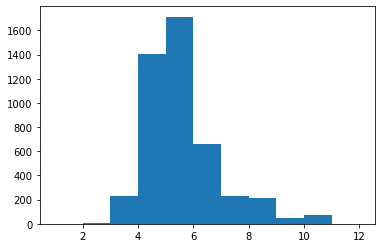

In [112]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

In [113]:
iters = simulate_robust_filter(G, W, 5, range(N), 0.2, False)

Result 0: 5    acc: 5.0                                    
Result 1: 5    acc: 5.0                                    
Result 2: 4    acc: 4.666666666666667                      
Result 3: 4    acc: 4.5                                    
Result 4: 5    acc: 4.6                                    
Result 5: 5    acc: 4.666666666666667                      
Result 6: 5    acc: 4.714285714285714                      
Result 7: 5    acc: 4.75                                   
Result 8: 5    acc: 4.777777777777778                      
Result 9: 5    acc: 4.8                                    
Result 10: 5    acc: 4.818181818181818                     
Result 11: 5    acc: 4.833333333333333                     
Result 12: 5    acc: 4.846153846153846                     
Result 13: 5    acc: 4.857142857142857                     
Result 14: 5    acc: 4.866666666666666                     
Result 15: 5    acc: 4.875                                 
Result 16: 4    acc: 4.823529411764706  

Result 273: 4    acc: 4.974452554744525                    
Result 274: 4    acc: 4.970909090909091                    
Result 275: 9    acc: 4.9855072463768115                   
Result 276: 11    acc: 5.007220216606498                   
Result 277: 11    acc: 5.028776978417266                   
Result 278: 6    acc: 5.032258064516129                    
Result 279: 5    acc: 5.0321428571428575                   
Result 280: 4    acc: 5.02846975088968                     
Result 281: 7    acc: 5.035460992907802                    
Result 282: 3    acc: 5.028268551236749                    
Result 283: 6    acc: 5.03169014084507                     
Result 284: 4    acc: 5.028070175438597                    
Result 285: 5    acc: 5.027972027972028                    
Result 286: 6    acc: 5.031358885017422                    
Result 287: 5    acc: 5.03125                              
Result 288: 6    acc: 5.034602076124568                    
Result 289: 6    acc: 5.037931034482758 

Result 410: 3    acc: 5.111922141119221                    
Result 411: 3    acc: 5.106796116504855                    
Result 412: 5    acc: 5.106537530266344                    
Result 413: 6    acc: 5.108695652173913                    
Result 414: 4    acc: 5.106024096385542                    
Result 415: 5    acc: 5.105769230769231                    
Result 416: 4    acc: 5.103117505995204                    
Result 417: 4    acc: 5.100478468899522                    
Result 418: 9    acc: 5.109785202863962                    
Result 419: 4    acc: 5.107142857142857                    
Result 420: 5    acc: 5.10688836104513                     
Result 421: 4    acc: 5.104265402843602                    
Result 422: 3    acc: 5.099290780141844                    
Result 423: 6    acc: 5.101415094339623                    
Result 424: 6    acc: 5.103529411764706                    
Result 425: 5    acc: 5.103286384976526                    
Result 426: 4    acc: 5.100702576112412 

Result 548: 5    acc: 5.120218579234972                    
Result 549: 5    acc: 5.12                                 
Result 550: 5    acc: 5.11978221415608                     
Result 551: 5    acc: 5.119565217391305                    
Result 552: 5    acc: 5.119349005424954                    
Result 553: 5    acc: 5.11913357400722                     
Result 554: 5    acc: 5.118918918918919                    
Result 555: 5    acc: 5.118705035971223                    
Result 556: 5    acc: 5.118491921005386                    
Result 557: 5    acc: 5.118279569892473                    
Result 558: 5    acc: 5.1180679785330945                   
Result 559: 5    acc: 5.117857142857143                    
Result 560: 5    acc: 5.117647058823529                    
Result 561: 5    acc: 5.117437722419929                    
Result 562: 5    acc: 5.1172291296625225                   
Result 563: 4    acc: 5.115248226950355                    
Result 564: 5    acc: 5.115044247787611 

Result 685: 4    acc: 5.034985422740525                    
Result 686: 4    acc: 5.033478893740902                    
Result 687: 5    acc: 5.03343023255814                     
Result 688: 4    acc: 5.031930333817126                    
Result 689: 5    acc: 5.0318840579710145                   
Result 690: 5    acc: 5.031837916063676                    
Result 691: 5    acc: 5.031791907514451                    
Result 692: 5    acc: 5.031746031746032                    
Result 693: 5    acc: 5.031700288184438                    
Result 694: 5    acc: 5.031654676258992                    
Result 695: 5    acc: 5.031609195402299                    
Result 696: 4    acc: 5.03012912482066                     
Result 697: 5    acc: 5.030085959885387                    
Result 698: 7    acc: 5.032904148783977                    
Result 699: 4    acc: 5.031428571428571                    
Result 700: 4    acc: 5.029957203994294                    
Result 701: 4    acc: 5.028490028490029 

Result 823: 4    acc: 5.032766990291262                    
Result 824: 4    acc: 5.031515151515151                    
Result 825: 5    acc: 5.031476997578692                    
Result 826: 5    acc: 5.031438935912938                    
Result 827: 5    acc: 5.031400966183575                    
Result 828: 4    acc: 5.030156815440289                    
Result 829: 6    acc: 5.031325301204819                    
Result 830: 4    acc: 5.030084235860409                    
Result 831: 4    acc: 5.028846153846154                    
Result 832: 4    acc: 5.0276110444177675                   
Result 833: 4    acc: 5.026378896882494                    
Result 834: 4    acc: 5.025149700598803                    
Result 835: 4    acc: 5.023923444976076                    
Result 836: 4    acc: 5.022700119474313                    
Result 837: 4    acc: 5.021479713603819                    
Result 838: 4    acc: 5.020262216924911                    
Result 839: 4    acc: 5.019047619047619 

Result 960: 4    acc: 4.975026014568158                    
Result 961: 4    acc: 4.974012474012474                    
Result 962: 4    acc: 4.973001038421599                    
Result 963: 4    acc: 4.971991701244813                    
Result 964: 4    acc: 4.97098445595855                     
Result 965: 4    acc: 4.969979296066253                    
Result 966: 4    acc: 4.968976215098242                    
Result 967: 4    acc: 4.9679752066115705                   
Result 968: 4    acc: 4.966976264189887                    
Result 969: 5    acc: 4.967010309278351                    
Result 970: 4    acc: 4.966014418125644                    
Result 971: 4    acc: 4.965020576131687                    
Result 972: 6    acc: 4.966084275436794                    
Result 973: 6    acc: 4.967145790554415                    
Result 974: 6    acc: 4.9682051282051285                   
Result 975: 6    acc: 4.969262295081967                    
Result 976: 4    acc: 4.968270214943705 

Result 1233: 5    acc: 4.905996758508914                   
Result 1234: 5    acc: 4.906072874493927                   
Result 1235: 5    acc: 4.906148867313916                   
Result 1236: 5    acc: 4.906224737267583                   
Result 1237: 5    acc: 4.906300484652665                   
Result 1238: 5    acc: 4.90637610976594                    
Result 1239: 6    acc: 4.907258064516129                   
Result 1240: 5    acc: 4.907332796132152                   
Result 1241: 5    acc: 4.907407407407407                   
Result 1242: 4    acc: 4.906677393403057                   
Result 1243: 4    acc: 4.905948553054662                   
Result 1244: 5    acc: 4.906024096385543                   
Result 1245: 4    acc: 4.90529695024077                    
Result 1246: 4    acc: 4.904570970328789                   
Result 1247: 4    acc: 4.903846153846154                   
Result 1248: 5    acc: 4.903923138510809                   
Result 1249: 5    acc: 4.904            

Result 1505: 5    acc: 4.872509960159363                   
Result 1506: 5    acc: 4.872594558725946                   
Result 1507: 5    acc: 4.872679045092839                   
Result 1508: 5    acc: 4.8727634194831015                  
Result 1509: 5    acc: 4.872847682119206                   
Result 1510: 4    acc: 4.872270019854401                   
Result 1511: 4    acc: 4.871693121693122                   
Result 1512: 5    acc: 4.871777924653007                   
Result 1513: 5    acc: 4.871862615587847                   
Result 1514: 5    acc: 4.871947194719472                   
Result 1515: 5    acc: 4.872031662269129                   
Result 1516: 5    acc: 4.872116018457482                   
Result 1517: 5    acc: 4.872200263504611                   
Result 1518: 5    acc: 4.87228439763002                    
Result 1519: 5    acc: 4.872368421052632                   
Result 1520: 5    acc: 4.872452333990796                   
Result 1521: 5    acc: 4.872536136662286

Result 1777: 4    acc: 4.8796400449943755                  
Result 1778: 4    acc: 4.879145587408656                   
Result 1779: 4    acc: 4.878651685393258                   
Result 1780: 4    acc: 4.878158338012352                   
Result 1781: 4    acc: 4.877665544332211                   
Result 1782: 5    acc: 4.877734155916994                   
Result 1783: 5    acc: 4.87780269058296                    
Result 1784: 5    acc: 4.877871148459384                   
Result 1785: 5    acc: 4.877939529675252                   
Result 1786: 5    acc: 4.878007834359261                   
Result 1787: 5    acc: 4.878076062639821                   
Result 1788: 5    acc: 4.8781442146450535                  
Result 1789: 4    acc: 4.877653631284916                   
Result 1790: 4    acc: 4.877163595756561                   
Result 1791: 4    acc: 4.876674107142857                   
Result 1792: 4    acc: 4.876185164528723                   
Result 1793: 4    acc: 4.875696767001115

Result 2050: 4    acc: 4.8405655777669425                  
Result 2051: 4    acc: 4.840155945419103                   
Result 2052: 4    acc: 4.839746712128592                   
Result 2053: 4    acc: 4.839337877312561                   
Result 2054: 6    acc: 4.839902676399027                   
Result 2055: 11    acc: 4.842898832684825                  
Result 2056: 3    acc: 4.842002916869227                   
Result 2057: 5    acc: 4.8420796890184645                  
Result 2058: 6    acc: 4.842642059252064                   
Result 2059: 6    acc: 4.843203883495145                   
Result 2060: 4    acc: 4.842794759825328                   
Result 2061: 4    acc: 4.842386032977692                   
Result 2062: 6    acc: 4.8429471643238005                  
Result 2063: 6    acc: 4.8435077519379846                  
Result 2064: 6    acc: 4.84406779661017                    
Result 2065: 6    acc: 4.844627299128751                   
Result 2066: 6    acc: 4.8451862602806  

Result 2324: 4    acc: 4.8025806451612905                  
Result 2325: 4    acc: 4.802235597592434                   
Result 2326: 4    acc: 4.801890846583584                   
Result 2327: 4    acc: 4.801546391752577                   
Result 2328: 4    acc: 4.8012022327179045                  
Result 2329: 4    acc: 4.800858369098712                   
Result 2330: 4    acc: 4.800514800514801                   
Result 2331: 4    acc: 4.800171526586621                   
Result 2332: 4    acc: 4.799828546935276                   
Result 2333: 4    acc: 4.799485861182519                   
Result 2334: 6    acc: 4.8                                 
Result 2335: 6    acc: 4.800513698630137                   
Result 2336: 4    acc: 4.800171159606333                   
Result 2337: 4    acc: 4.7998289136013685                  
Result 2338: 4    acc: 4.799486960239419                   
Result 2339: 4    acc: 4.799145299145299                   
Result 2340: 4    acc: 4.798803929944468

Result 2462: 4    acc: 4.846122614697523                   
Result 2463: 6    acc: 4.846590909090909                   
Result 2464: 4    acc: 4.846247464503042                   
Result 2465: 4    acc: 4.845904298459043                   
Result 2466: 4    acc: 4.845561410620187                   
Result 2467: 4    acc: 4.845218800648298                   
Result 2468: 4    acc: 4.844876468205752                   
Result 2469: 4    acc: 4.844534412955466                   
Result 2470: 4    acc: 4.8441926345609065                  
Result 2471: 4    acc: 4.843851132686084                   
Result 2472: 4    acc: 4.843509906995552                   
Result 2473: 4    acc: 4.843168957154406                   
Result 2474: 4    acc: 4.8428282828282825                  
Result 2475: 4    acc: 4.8424878836833605                  
Result 2476: 4    acc: 4.8421477593863544                  
Result 2477: 4    acc: 4.84180790960452                    
Result 2478: 4    acc: 4.841468334005647

Result 2600: 5    acc: 4.831218762014609                   
Result 2601: 5    acc: 4.831283627978478                   
Result 2602: 5    acc: 4.831348444102958                   
Result 2603: 5    acc: 4.831413210445469                   
Result 2604: 4    acc: 4.8310940499040305                  
Result 2605: 5    acc: 4.831158864159631                   
Result 2606: 5    acc: 4.831223628691983                   
Result 2607: 5    acc: 4.831288343558282                   
Result 2608: 5    acc: 4.831353008815638                   
Result 2609: 5    acc: 4.831417624521073                   
Result 2610: 5    acc: 4.831482190731521                   
Result 2611: 5    acc: 4.831546707503828                   
Result 2612: 5    acc: 4.831611174894757                   
Result 2613: 7    acc: 4.832440703902066                   
Result 2614: 7    acc: 4.8332695984703635                  
Result 2615: 6    acc: 4.833715596330276                   
Result 2616: 8    acc: 4.834925487199083

Result 2739: 4    acc: 4.84963503649635                    
Result 2740: 4    acc: 4.849325063845312                   
Result 2741: 6    acc: 4.849744711889132                   
Result 2742: 6    acc: 4.850164053955523                   
Result 2743: 4    acc: 4.849854227405248                   
Result 2744: 5    acc: 4.849908925318761                   
Result 2745: 4    acc: 4.849599417334304                   
Result 2746: 5    acc: 4.849654168183473                   
Result 2747: 5    acc: 4.8497088791848615                  
Result 2748: 5    acc: 4.849763550381957                   
Result 2749: 5    acc: 4.849818181818182                   
Result 2750: 5    acc: 4.849872773536895                   
Result 2751: 10    acc: 4.851744186046512                  
Result 2752: 8    acc: 4.852887758808572                   
Result 2753: 8    acc: 4.8540305010893245                  
Result 2754: 5    acc: 4.854083484573502                   
Result 2755: 8    acc: 4.855224963715529

Result 2877: 4    acc: 4.873175816539264                   
Result 2878: 4    acc: 4.872872525182355                   
Result 2879: 8    acc: 4.873958333333333                   
Result 2880: 8    acc: 4.8750433877126                     
Result 2881: 8    acc: 4.876127689104789                   
Result 2882: 8    acc: 4.8772112382934445                  
Result 2883: 8    acc: 4.8782940360610265                  
Result 2884: 8    acc: 4.879376083188908                   
Result 2885: 8    acc: 4.88045738045738                    
Result 2886: 8    acc: 4.881537928645653                   
Result 2887: 8    acc: 4.882617728531856                   
Result 2888: 8    acc: 4.883696780893042                   
Result 2889: 8    acc: 4.88477508650519                    
Result 2890: 8    acc: 4.885852646143203                   
Result 2891: 8    acc: 4.886929460580913                   
Result 2892: 8    acc: 4.888005530591082                   
Result 2893: 8    acc: 4.889080856945404

Result 3015: 3    acc: 4.8753315649867375                  
Result 3016: 4    acc: 4.87504143188598                    
Result 3017: 5    acc: 4.875082836315441                   
Result 3018: 5    acc: 4.875124213315668                   
Result 3019: 5    acc: 4.8751655629139075                  
Result 3020: 5    acc: 4.875206885137372                   
Result 3021: 5    acc: 4.875248180013236                   
Result 3022: 5    acc: 4.87528944756864                    
Result 3023: 5    acc: 4.8753306878306875                  
Result 3024: 5    acc: 4.875371900826447                   
Result 3025: 5    acc: 4.875413086582948                   
Result 3026: 5    acc: 4.875454245127188                   
Result 3027: 5    acc: 4.875495376486129                   
Result 3028: 5    acc: 4.875536480686695                   
Result 3029: 5    acc: 4.875577557755776                   
Result 3030: 5    acc: 4.875618607720225                   
Result 3031: 5    acc: 4.87565963060686 

Result 3288: 7    acc: 4.95621769534813                    
Result 3289: 6    acc: 4.956534954407295                   
Result 3290: 7    acc: 4.9571558796718325                  
Result 3291: 6    acc: 4.957472660996355                   
Result 3292: 7    acc: 4.958092924385059                   
Result 3293: 6    acc: 4.958409228901032                   
Result 3294: 7    acc: 4.959028831562974                   
Result 3295: 7    acc: 4.959648058252427                   
Result 3296: 7    acc: 4.960266909311495                   
Result 3297: 7    acc: 4.960885385081868                   
Result 3298: 7    acc: 4.96150348590482                    
Result 3299: 7    acc: 4.962121212121212                   
Result 3300: 7    acc: 4.962738564071493                   
Result 3301: 7    acc: 4.9633555420957                     
Result 3302: 7    acc: 4.963972146533455                   
Result 3303: 7    acc: 4.964588377723971                   
Result 3304: 7    acc: 4.965204236006051

Result 3425: 4    acc: 5.039696438995914                   
Result 3426: 4    acc: 5.039393055150277                   
Result 3427: 6    acc: 5.039673278879813                   
Result 3428: 6    acc: 5.039953339165938                   
Result 3429: 5    acc: 5.039941690962099                   
Result 3430: 5    acc: 5.039930049548237                   
Result 3431: 5    acc: 5.039918414918415                   
Result 3432: 8    acc: 5.040780658316342                   
Result 3433: 5    acc: 5.040768782760629                   
Result 3434: 5    acc: 5.04075691411936                    
Result 3435: 5    acc: 5.040745052386496                   
Result 3436: 5    acc: 5.040733197556008                   
Result 3437: 6    acc: 5.041012216404886                   
Result 3438: 6    acc: 5.041291072986334                   
Result 3439: 5    acc: 5.041279069767442                   
Result 3440: 5    acc: 5.041267073525138                   
Result 3441: 5    acc: 5.041255084253341

Result 3562: 4    acc: 5.057535784451305                   
Result 3563: 4    acc: 5.057239057239057                   
Result 3564: 5    acc: 5.057223001402525                   
Result 3565: 6    acc: 5.057487380818845                   
Result 3566: 8    acc: 5.058312307261003                   
Result 3567: 8    acc: 5.059136771300448                   
Result 3568: 8    acc: 5.059960773325861                   
Result 3569: 6    acc: 5.060224089635854                   
Result 3570: 6    acc: 5.060487258471016                   
Result 3571: 5    acc: 5.0604703247480405                  
Result 3572: 6    acc: 5.060733277357962                   
Result 3573: 6    acc: 5.0609960828203695                  
Result 3574: 6    acc: 5.061258741258741                   
Result 3575: 6    acc: 5.06152125279642                    
Result 3576: 6    acc: 5.061783617556611                   
Result 3577: 5    acc: 5.061766349916154                   
Result 3578: 6    acc: 5.062028499580888

Result 3700: 3    acc: 5.06863009997298                    
Result 3701: 3    acc: 5.06807131280389                    
Result 3702: 5    acc: 5.0680529300567105                  
Result 3703: 5    acc: 5.068034557235421                   
Result 3704: 4    acc: 5.06774628879892                    
Result 3705: 4    acc: 5.0674581759309225                  
Result 3706: 4    acc: 5.06717021850553                    
Result 3707: 4    acc: 5.06688241639698                    
Result 3708: 4    acc: 5.066594769479644                   
Result 3709: 4    acc: 5.066307277628033                   
Result 3710: 4    acc: 5.066019940716788                   
Result 3711: 4    acc: 5.0657327586206895                  
Result 3712: 4    acc: 5.065445731214651                   
Result 3713: 4    acc: 5.065158858373721                   
Result 3714: 4    acc: 5.064872139973082                   
Result 3715: 4    acc: 5.064585575888052                   
Result 3716: 4    acc: 5.064299165994081

Result 3838: 5    acc: 5.063558218286012                   
Result 3839: 5    acc: 5.063541666666667                   
Result 3840: 5    acc: 5.063525123665712                   
Result 3841: 5    acc: 5.0635085892764184                  
Result 3842: 4    acc: 5.063231850117096                   
Result 3843: 8    acc: 5.063995837669094                   
Result 3844: 4    acc: 5.06371911573472                    
Result 3845: 4    acc: 5.063442537701508                   
Result 3846: 4    acc: 5.063166103457239                   
Result 3847: 4    acc: 5.0628898128898125                  
Result 3848: 5    acc: 5.062873473629514                   
Result 3849: 4    acc: 5.062597402597403                   
Result 3850: 4    acc: 5.062321474941574                   
Result 3851: 8    acc: 5.063084112149533                   
Result 3852: 8    acc: 5.063846353490787                   
Result 3853: 8    acc: 5.064608199273482                   
Result 3854: 8    acc: 5.065369649805447

Result 3975: 6    acc: 5.07897384305835                    
Result 3976: 6    acc: 5.07920543122957                    
Result 3977: 5    acc: 5.079185520361991                   
Result 3978: 5    acc: 5.079165619502388                   
Result 3979: 6    acc: 5.079396984924623                   
Result 3980: 5    acc: 5.079377040944486                   
Result 3981: 5    acc: 5.0793571069814165                  
Result 3982: 5    acc: 5.079337183027868                   
Result 3983: 5    acc: 5.079317269076305                   
Result 3984: 5    acc: 5.079297365119197                   
Result 3985: 5    acc: 5.079277471149021                   
Result 3986: 5    acc: 5.079257587158264                   
Result 3987: 5    acc: 5.079237713139419                   
Result 3988: 5    acc: 5.0792178490849835                  
Result 3989: 6    acc: 5.079448621553885                   
Result 3990: 5    acc: 5.079428714607868                   
Result 3991: 6    acc: 5.079659318637274

Result 4247: 6    acc: 5.088983050847458                   
Result 4248: 7    acc: 5.089432807719463                   
Result 4249: 6    acc: 5.089647058823529                   
Result 4250: 8    acc: 5.090331686661962                   
Result 4251: 5    acc: 5.090310442144873                   
Result 4252: 4    acc: 5.090054079473313                   
Result 4253: 5    acc: 5.090032910202162                   
Result 4254: 6    acc: 5.0902467685076385                  
Result 4255: 5    acc: 5.090225563909774                   
Result 4256: 5    acc: 5.0902043692741366                  
Result 4257: 4    acc: 5.0899483325504935                  
Result 4258: 4    acc: 5.089692416060108                   
Result 4259: 4    acc: 5.08943661971831                    
Result 4260: 4    acc: 5.089180943440507                   
Result 4261: 7    acc: 5.089629282027217                   
Result 4262: 5    acc: 5.089608257095942                   
Result 4263: 5    acc: 5.089587242026266

Result 4384: 6    acc: 5.117217787913341                   
Result 4385: 6    acc: 5.1174190606475145                  
Result 4386: 6    acc: 5.117620241622977                   
Result 4387: 6    acc: 5.117821330902461                   
Result 4388: 6    acc: 5.118022328548644                   
Result 4389: 5    acc: 5.117995444191344                   
Result 4390: 5    acc: 5.117968572079253                   
Result 4391: 5    acc: 5.117941712204007                   
Result 4392: 5    acc: 5.1179148645572505                  
Result 4393: 4    acc: 5.117660446062813                   
Result 4394: 5    acc: 5.1176336746302615                  
Result 4395: 5    acc: 5.117606915377616                   
Result 4396: 5    acc: 5.117580168296566                   
Result 4397: 4    acc: 5.117326057298772                   
Result 4398: 4    acc: 5.117072061832235                   
Result 4399: 3    acc: 5.116590909090909                   
Result 4400: 4    acc: 5.116337196091798

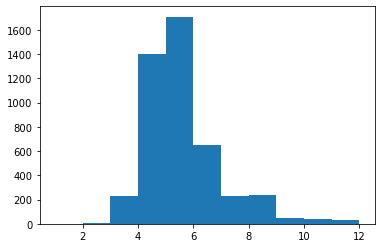

In [114]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

In [115]:
iters = simulate_robust_filter(G, W, 5, range(N), 0.4, False)

Result 0: 5    acc: 5.0                                    
Result 1: 5    acc: 5.0                                    
Result 2: 4    acc: 4.666666666666667                      
Result 3: 4    acc: 4.5                                    
Result 4: 5    acc: 4.6                                    
Result 5: 5    acc: 4.666666666666667                      
Result 6: 5    acc: 4.714285714285714                      
Result 7: 5    acc: 4.75                                   
Result 8: 5    acc: 4.777777777777778                      
Result 9: 5    acc: 4.8                                    
Result 10: 5    acc: 4.818181818181818                     
Result 11: 5    acc: 4.833333333333333                     
Result 12: 5    acc: 4.846153846153846                     
Result 13: 5    acc: 4.857142857142857                     
Result 14: 4    acc: 4.8                                   
Result 15: 5    acc: 4.8125                                
Result 16: 5    acc: 4.823529411764706  

Result 273: 4    acc: 4.95985401459854                     
Result 274: 4    acc: 4.956363636363636                    
Result 275: 9    acc: 4.971014492753623                    
Result 276: 9    acc: 4.985559566787003                    
Result 277: 9    acc: 5.0                                  
Result 278: 6    acc: 5.003584229390681                    
Result 279: 5    acc: 5.003571428571429                    
Result 280: 4    acc: 5.0                                  
Result 281: 7    acc: 5.00709219858156                     
Result 282: 3    acc: 5.0                                  
Result 283: 6    acc: 5.003521126760563                    
Result 284: 4    acc: 5.0                                  
Result 285: 5    acc: 5.0                                  
Result 286: 5    acc: 5.0                                  
Result 287: 7    acc: 5.006944444444445                    
Result 288: 6    acc: 5.010380622837371                    
Result 289: 6    acc: 5.0137931034482754

Result 410: 3    acc: 5.099756690997567                    
Result 411: 3    acc: 5.094660194174757                    
Result 412: 5    acc: 5.094430992736077                    
Result 413: 6    acc: 5.096618357487923                    
Result 414: 4    acc: 5.093975903614457                    
Result 415: 5    acc: 5.09375                              
Result 416: 4    acc: 5.091127098321343                    
Result 417: 4    acc: 5.088516746411483                    
Result 418: 9    acc: 5.097852028639618                    
Result 419: 4    acc: 5.095238095238095                    
Result 420: 5    acc: 5.095011876484561                    
Result 421: 4    acc: 5.092417061611374                    
Result 422: 3    acc: 5.087470449172577                    
Result 423: 6    acc: 5.089622641509434                    
Result 424: 6    acc: 5.091764705882353                    
Result 425: 5    acc: 5.091549295774648                    
Result 426: 4    acc: 5.0889929742388755

Result 547: 4    acc: 5.12043795620438                     
Result 548: 5    acc: 5.120218579234972                    
Result 549: 5    acc: 5.12                                 
Result 550: 5    acc: 5.11978221415608                     
Result 551: 5    acc: 5.119565217391305                    
Result 552: 5    acc: 5.119349005424954                    
Result 553: 5    acc: 5.11913357400722                     
Result 554: 5    acc: 5.118918918918919                    
Result 555: 5    acc: 5.118705035971223                    
Result 556: 5    acc: 5.118491921005386                    
Result 557: 5    acc: 5.118279569892473                    
Result 558: 5    acc: 5.1180679785330945                   
Result 559: 5    acc: 5.117857142857143                    
Result 560: 5    acc: 5.117647058823529                    
Result 561: 5    acc: 5.117437722419929                    
Result 562: 5    acc: 5.1172291296625225                   
Result 563: 4    acc: 5.115248226950355 

Result 684: 4    acc: 5.054014598540146                    
Result 685: 4    acc: 5.052478134110787                    
Result 686: 4    acc: 5.0509461426492                      
Result 687: 5    acc: 5.050872093023256                    
Result 688: 4    acc: 5.049346879535559                    
Result 689: 5    acc: 5.04927536231884                     
Result 690: 5    acc: 5.049204052098408                    
Result 691: 5    acc: 5.0491329479768785                   
Result 692: 5    acc: 5.049062049062049                    
Result 693: 5    acc: 5.0489913544668585                   
Result 694: 5    acc: 5.048920863309353                    
Result 695: 5    acc: 5.0488505747126435                   
Result 696: 4    acc: 5.047345767575322                    
Result 697: 5    acc: 5.04727793696275                     
Result 698: 7    acc: 5.050071530758226                    
Result 699: 4    acc: 5.048571428571429                    
Result 700: 4    acc: 5.0470756062767475

Result 957: 4    acc: 4.979123173277662                    
Result 958: 4    acc: 4.978102189781022                    
Result 959: 4    acc: 4.977083333333334                    
Result 960: 4    acc: 4.976066597294485                    
Result 961: 4    acc: 4.975051975051975                    
Result 962: 4    acc: 4.9740394600207685                   
Result 963: 4    acc: 4.973029045643154                    
Result 964: 4    acc: 4.972020725388601                    
Result 965: 4    acc: 4.971014492753623                    
Result 966: 4    acc: 4.970010341261634                    
Result 967: 4    acc: 4.9690082644628095                   
Result 968: 4    acc: 4.9680082559339525                   
Result 969: 5    acc: 4.968041237113402                    
Result 970: 4    acc: 4.967044284243048                    
Result 971: 4    acc: 4.966049382716049                    
Result 972: 6    acc: 4.9671120246659815                   
Result 973: 6    acc: 4.968172484599589 

Result 1230: 5    acc: 4.90982940698619                    
Result 1231: 5    acc: 4.909902597402597                   
Result 1232: 5    acc: 4.909975669099757                   
Result 1233: 5    acc: 4.910048622366289                   
Result 1234: 5    acc: 4.910121457489878                   
Result 1235: 5    acc: 4.910194174757281                   
Result 1236: 5    acc: 4.910266774454325                   
Result 1237: 5    acc: 4.910339256865913                   
Result 1238: 5    acc: 4.910411622276029                   
Result 1239: 5    acc: 4.910483870967742                   
Result 1240: 5    acc: 4.910556003223207                   
Result 1241: 5    acc: 4.9106280193236715                  
Result 1242: 4    acc: 4.909895414320193                   
Result 1243: 4    acc: 4.909163987138264                   
Result 1244: 5    acc: 4.909236947791165                   
Result 1245: 4    acc: 4.908507223113965                   
Result 1246: 4    acc: 4.907778668805133

Result 1367: 6    acc: 4.885964912280702                   
Result 1368: 6    acc: 4.886778670562454                   
Result 1369: 6    acc: 4.887591240875913                   
Result 1370: 6    acc: 4.888402625820569                   
Result 1371: 6    acc: 4.889212827988338                   
Result 1372: 6    acc: 4.890021849963583                   
Result 1373: 6    acc: 4.890829694323144                   
Result 1374: 5    acc: 4.890909090909091                   
Result 1375: 5    acc: 4.890988372093023                   
Result 1376: 4    acc: 4.890341321713871                   
Result 1377: 5    acc: 4.890420899854862                   
Result 1378: 5    acc: 4.890500362581581                   
Result 1379: 5    acc: 4.8905797101449275                  
Result 1380: 5    acc: 4.890658942795076                   
Result 1381: 5    acc: 4.8907380607814765                  
Result 1382: 5    acc: 4.890817064352856                   
Result 1383: 5    acc: 4.890895953757226

Result 1504: 4    acc: 4.869767441860465                   
Result 1505: 5    acc: 4.869853917662683                   
Result 1506: 5    acc: 4.869940278699403                   
Result 1507: 5    acc: 4.870026525198939                   
Result 1508: 5    acc: 4.870112657388999                   
Result 1509: 5    acc: 4.870198675496689                   
Result 1510: 4    acc: 4.869622766379881                   
Result 1511: 4    acc: 4.869047619047619                   
Result 1512: 5    acc: 4.869134170522141                   
Result 1513: 5    acc: 4.869220607661823                   
Result 1514: 5    acc: 4.869306930693069                   
Result 1515: 5    acc: 4.869393139841689                   
Result 1516: 5    acc: 4.869479235332894                   
Result 1517: 5    acc: 4.869565217391305                   
Result 1518: 5    acc: 4.869651086240948                   
Result 1519: 5    acc: 4.869736842105263                   
Result 1520: 5    acc: 4.8698224852071  

Result 1643: 5    acc: 4.894768856447689                   
Result 1644: 5    acc: 4.89483282674772                    
Result 1645: 6    acc: 4.8955042527339                     
Result 1646: 5    acc: 4.895567698846388                   
Result 1647: 7    acc: 4.896844660194175                   
Result 1648: 7    acc: 4.898120072771377                   
Result 1649: 6    acc: 4.8987878787878785                  
Result 1650: 5    acc: 4.898849182313749                   
Result 1651: 5    acc: 4.898910411622276                   
Result 1652: 5    acc: 4.898971566848155                   
Result 1653: 5    acc: 4.899032648125756                   
Result 1654: 5    acc: 4.899093655589124                   
Result 1655: 7    acc: 4.90036231884058                    
Result 1656: 5    acc: 4.9004224502112255                  
Result 1657: 5    acc: 4.900482509047045                   
Result 1658: 5    acc: 4.900542495479204                   
Result 1659: 5    acc: 4.900602409638554

Result 1780: 4    acc: 4.880404267265581                   
Result 1781: 4    acc: 4.879910213243547                   
Result 1782: 5    acc: 4.879977565900168                   
Result 1783: 5    acc: 4.880044843049327                   
Result 1784: 5    acc: 4.880112044817928                   
Result 1785: 5    acc: 4.880179171332586                   
Result 1786: 5    acc: 4.8802462227196415                  
Result 1787: 5    acc: 4.880313199105146                   
Result 1788: 5    acc: 4.880380100614869                   
Result 1789: 4    acc: 4.879888268156424                   
Result 1790: 4    acc: 4.8793969849246235                  
Result 1791: 4    acc: 4.87890625                          
Result 1792: 4    acc: 4.878416062465142                   
Result 1793: 4    acc: 4.877926421404682                   
Result 1794: 5    acc: 4.87799442896936                    
Result 1795: 6    acc: 4.878619153674833                   
Result 1796: 3    acc: 4.877573734001113

Result 2053: 4    acc: 4.84031158714703                    
Result 2054: 6    acc: 4.840875912408759                   
Result 2055: 11    acc: 4.843871595330739                  
Result 2056: 3    acc: 4.8429752066115705                  
Result 2057: 5    acc: 4.8430515063168125                  
Result 2058: 6    acc: 4.843613404565323                   
Result 2059: 6    acc: 4.844174757281554                   
Result 2060: 4    acc: 4.843765162542455                   
Result 2061: 4    acc: 4.843355965082444                   
Result 2062: 6    acc: 4.843916626272419                   
Result 2063: 6    acc: 4.844476744186046                   
Result 2064: 6    acc: 4.845036319612591                   
Result 2065: 6    acc: 4.845595353339787                   
Result 2066: 6    acc: 4.846153846153846                   
Result 2067: 6    acc: 4.846711798839459                   
Result 2068: 6    acc: 4.847269212179797                   
Result 2069: 5    acc: 4.847342995169082

Result 2190: 5    acc: 4.813783660429028                   
Result 2191: 5    acc: 4.813868613138686                   
Result 2192: 5    acc: 4.813953488372093                   
Result 2193: 5    acc: 4.814038286235187                   
Result 2194: 5    acc: 4.814123006833713                   
Result 2195: 5    acc: 4.814207650273224                   
Result 2196: 5    acc: 4.814292216659081                   
Result 2197: 5    acc: 4.814376706096452                   
Result 2198: 5    acc: 4.814461118690314                   
Result 2199: 5    acc: 4.8145454545454545                  
Result 2200: 5    acc: 4.81462971376647                    
Result 2201: 5    acc: 4.814713896457766                   
Result 2202: 5    acc: 4.814798002723559                   
Result 2203: 5    acc: 4.814882032667876                   
Result 2204: 5    acc: 4.814965986394558                   
Result 2205: 5    acc: 4.8150498640072525                  
Result 2206: 5    acc: 4.815133665609425

Result 2327: 4    acc: 4.80713058419244                    
Result 2328: 4    acc: 4.806784027479605                   
Result 2329: 4    acc: 4.806437768240343                   
Result 2330: 4    acc: 4.806091806091806                   
Result 2331: 4    acc: 4.805746140651801                   
Result 2332: 4    acc: 4.805400771538792                   
Result 2333: 4    acc: 4.805055698371894                   
Result 2334: 6    acc: 4.805567451820129                   
Result 2335: 6    acc: 4.806078767123288                   
Result 2336: 4    acc: 4.805733846812152                   
Result 2337: 4    acc: 4.8053892215568865                  
Result 2338: 4    acc: 4.805044890979051                   
Result 2339: 4    acc: 4.8047008547008545                  
Result 2340: 4    acc: 4.804357112345151                   
Result 2341: 4    acc: 4.80401366353544                    
Result 2342: 4    acc: 4.80367050789586                    
Result 2343: 4    acc: 4.803327645051194

Result 2465: 4    acc: 4.847931873479319                   
Result 2466: 4    acc: 4.847588163761654                   
Result 2467: 4    acc: 4.847244732576986                   
Result 2468: 4    acc: 4.846901579586877                   
Result 2469: 4    acc: 4.846558704453441                   
Result 2470: 4    acc: 4.846216106839337                   
Result 2471: 4    acc: 4.845873786407767                   
Result 2472: 4    acc: 4.845531742822483                   
Result 2473: 4    acc: 4.845189975747777                   
Result 2474: 4    acc: 4.844848484848485                   
Result 2475: 4    acc: 4.844507269789984                   
Result 2476: 4    acc: 4.844166330238191                   
Result 2477: 4    acc: 4.843825665859564                   
Result 2478: 4    acc: 4.843485276321097                   
Result 2479: 4    acc: 4.843145161290322                   
Result 2480: 6    acc: 4.843611446997179                   
Result 2481: 6    acc: 4.844077356970185

Result 2602: 5    acc: 4.833653476757587                   
Result 2603: 5    acc: 4.833717357910906                   
Result 2604: 4    acc: 4.833397312859885                   
Result 2605: 5    acc: 4.833461243284727                   
Result 2606: 8    acc: 4.834675872650556                   
Result 2607: 8    acc: 4.835889570552148                   
Result 2608: 8    acc: 4.83710233806056                    
Result 2609: 5    acc: 4.837164750957855                   
Result 2610: 5    acc: 4.837227116047491                   
Result 2611: 5    acc: 4.83728943338438                    
Result 2612: 5    acc: 4.837351703023344                   
Result 2613: 7    acc: 4.838179035960215                   
Result 2614: 7    acc: 4.8390057361376675                  
Result 2615: 7    acc: 4.839831804281346                   
Result 2616: 7    acc: 4.840657241115782                   
Result 2617: 5    acc: 4.840718105423988                   
Result 2618: 7    acc: 4.841542573501337

Result 2875: 4    acc: 4.886300417246175                   
Result 2876: 4    acc: 4.885992353145638                   
Result 2877: 4    acc: 4.885684503127171                   
Result 2878: 4    acc: 4.885376866967697                   
Result 2879: 8    acc: 4.886458333333334                   
Result 2880: 8    acc: 4.88753904894134                    
Result 2881: 8    acc: 4.888619014573213                   
Result 2882: 8    acc: 4.8896982310093655                  
Result 2883: 8    acc: 4.890776699029126                   
Result 2884: 8    acc: 4.891854419410746                   
Result 2885: 8    acc: 4.892931392931393                   
Result 2886: 8    acc: 4.894007620367163                   
Result 2887: 8    acc: 4.895083102493075                   
Result 2888: 8    acc: 4.896157840083074                   
Result 2889: 8    acc: 4.897231833910035                   
Result 2890: 8    acc: 4.898305084745763                   
Result 2891: 8    acc: 4.899377593360996

Result 3148: 8    acc: 4.944744363289933                   
Result 3149: 8    acc: 4.945714285714286                   
Result 3150: 8    acc: 4.946683592510314                   
Result 3151: 9    acc: 4.947969543147208                   
Result 3152: 9    acc: 4.9492546780843645                  
Result 3153: 9    acc: 4.950538998097654                   
Result 3154: 9    acc: 4.951822503961965                   
Result 3155: 8    acc: 4.952788339670469                   
Result 3156: 4    acc: 4.9524865378523915                  
Result 3157: 4    acc: 4.952184927169094                   
Result 3158: 4    acc: 4.951883507439063                   
Result 3159: 4    acc: 4.951582278481013                   
Result 3160: 4    acc: 4.951281240113888                   
Result 3161: 5    acc: 4.9512966476913345                  
Result 3162: 5    acc: 4.951312045526399                   
Result 3163: 5    acc: 4.951327433628318                   
Result 3164: 5    acc: 4.951342812006319

Result 3421: 5    acc: 5.05260081823495                    
Result 3422: 5    acc: 5.052585451358458                   
Result 3423: 5    acc: 5.052570093457944                   
Result 3424: 5    acc: 5.052554744525548                   
Result 3425: 4    acc: 5.052247518972563                   
Result 3426: 4    acc: 5.0519404727166615                  
Result 3427: 5    acc: 5.051925320886815                   
Result 3428: 5    acc: 5.05191017789443                    
Result 3429: 5    acc: 5.051895043731778                   
Result 3430: 5    acc: 5.05187991839114                    
Result 3431: 5    acc: 5.051864801864802                   
Result 3432: 8    acc: 5.0527235653946985                  
Result 3433: 5    acc: 5.05270821199767                    
Result 3434: 5    acc: 5.0526928675400296                  
Result 3435: 5    acc: 5.05267753201397                    
Result 3436: 5    acc: 5.052662205411696                   
Result 3437: 5    acc: 5.052646887725421

Result 3559: 5    acc: 5.0705056179775285                  
Result 3560: 5    acc: 5.070485818590283                   
Result 3561: 5    acc: 5.070466030320045                   
Result 3562: 5    acc: 5.070446253157452                   
Result 3563: 4    acc: 5.070145903479236                   
Result 3564: 5    acc: 5.070126227208976                   
Result 3565: 5    acc: 5.0701065619742005                  
Result 3566: 10    acc: 5.071488645920942                  
Result 3567: 10    acc: 5.072869955156951                  
Result 3568: 10    acc: 5.0742504903334265                 
Result 3569: 6    acc: 5.074509803921568                   
Result 3570: 6    acc: 5.074768972276673                   
Result 3571: 6    acc: 5.075027995520717                   
Result 3572: 7    acc: 5.075566750629723                   
Result 3573: 7    acc: 5.076105204252938                   
Result 3574: 7    acc: 5.076643356643356                   
Result 3575: 7    acc: 5.077181208053691

Result 3831: 4    acc: 5.090031315240084                   
Result 3832: 4    acc: 5.089746934516045                   
Result 3833: 4    acc: 5.089462702138759                   
Result 3834: 4    acc: 5.089178617992177                   
Result 3835: 5    acc: 5.089155370177268                   
Result 3836: 5    acc: 5.089132134480063                   
Result 3837: 5    acc: 5.089108910891089                   
Result 3838: 5    acc: 5.0890856994008855                  
Result 3839: 5    acc: 5.0890625                           
Result 3840: 5    acc: 5.08903931267899                    
Result 3841: 5    acc: 5.089016137428422                   
Result 3842: 4    acc: 5.088732760863908                   
Result 3843: 8    acc: 5.0894901144641                     
Result 3844: 4    acc: 5.089206762028609                   
Result 3845: 4    acc: 5.0889235569422775                  
Result 3846: 4    acc: 5.0886404990902                     
Result 3847: 4    acc: 5.088357588357589

Result 3969: 6    acc: 5.101007556675063                   
Result 3970: 6    acc: 5.101233946109292                   
Result 3971: 6    acc: 5.101460221550856                   
Result 3972: 6    acc: 5.10168638308583                    
Result 3973: 6    acc: 5.101912430800201                   
Result 3974: 6    acc: 5.102138364779874                   
Result 3975: 6    acc: 5.102364185110664                   
Result 3976: 6    acc: 5.1025898918783                     
Result 3977: 5    acc: 5.102564102564102                   
Result 3978: 5    acc: 5.102538326212616                   
Result 3979: 5    acc: 5.10251256281407                    
Result 3980: 5    acc: 5.102486812358704                   
Result 3981: 5    acc: 5.102461074836765                   
Result 3982: 5    acc: 5.102435350238514                   
Result 3983: 5    acc: 5.102409638554217                   
Result 3984: 5    acc: 5.102383939774153                   
Result 3985: 5    acc: 5.10235825388861 

Result 4242: 7    acc: 5.0956870139052555                  
Result 4243: 9    acc: 5.0966069745523095                  
Result 4244: 9    acc: 5.097526501766785                   
Result 4245: 6    acc: 5.09773904851625                    
Result 4246: 6    acc: 5.097951495173064                   
Result 4247: 6    acc: 5.09816384180791                    
Result 4248: 7    acc: 5.098611437985408                   
Result 4249: 6    acc: 5.0988235294117645                  
Result 4250: 8    acc: 5.099505998588567                   
Result 4251: 5    acc: 5.0994825964252115                  
Result 4252: 4    acc: 5.099224077122032                   
Result 4253: 5    acc: 5.099200752233192                   
Result 4254: 6    acc: 5.099412455934195                   
Result 4255: 5    acc: 5.0993890977443606                  
Result 4256: 5    acc: 5.099365750528541                   
Result 4257: 4    acc: 5.099107562235791                   
Result 4258: 4    acc: 5.098849495186664

Result 4515: 5    acc: 5.122674933569531                   
Result 4516: 5    acc: 5.12264777507195                    
Result 4517: 5    acc: 5.122620628596724                   
Result 4518: 3    acc: 5.122150918344767                   
Result 4519: 7    acc: 5.122566371681416                   
Result 4520: 7    acc: 5.122981641229816                   
Result 4521: 7    acc: 5.123396727111897                   
Result 4522: 7    acc: 5.123811629449481                   
Result 4523: 7    acc: 5.12422634836428                    
Result 4524: 7    acc: 5.124640883977901                   
Result 4525: 7    acc: 5.125055236411843                   
Result 4526: 7    acc: 5.125469405787498                   
Result 4527: 7    acc: 5.125883392226148                   
Result 4528: 7    acc: 5.126297195848974                   
Result 4529: 6    acc: 5.126490066225165                   
Result 4530: 6    acc: 5.126682851467667                   
Result 4531: 6    acc: 5.126875551632833

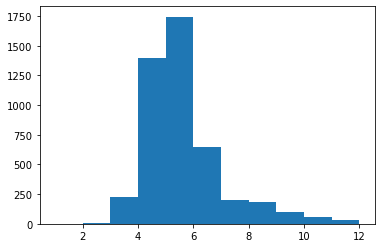

In [116]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

In [117]:
iters = simulate_robust_filter(G, W, 5, range(N), 0.6, False)

Result 0: 5    acc: 5.0                                    
Result 1: 5    acc: 5.0                                    
Result 2: 5    acc: 5.0                                    
Result 3: 5    acc: 5.0                                    
Result 4: 5    acc: 5.0                                    
Result 5: 6    acc: 5.166666666666667                      
Result 6: 5    acc: 5.142857142857143                      
Result 7: 5    acc: 5.125                                  
Result 8: 5    acc: 5.111111111111111                      
Result 9: 5    acc: 5.1                                    
Result 10: 5    acc: 5.090909090909091                     
Result 11: 5    acc: 5.083333333333333                     
Result 12: 5    acc: 5.076923076923077                     
Result 13: 4    acc: 5.0                                   
Result 14: 4    acc: 4.933333333333334                     
Result 15: 4    acc: 4.875                                 
Result 16: 4    acc: 4.823529411764706  

Result 272: 8    acc: 5.197802197802198                    
Result 273: 8    acc: 5.208029197080292                    
Result 274: 13    acc: 5.236363636363636                   
Result 275: 13    acc: 5.2644927536231885                  
Result 276: 16    acc: 5.303249097472924                   
Result 277: 16    acc: 5.341726618705036                   
Result 278: 7    acc: 5.347670250896058                    
Result 279: 5    acc: 5.3464285714285715                   
Result 280: 4    acc: 5.341637010676156                    
Result 281: 4    acc: 5.336879432624113                    
Result 282: 3    acc: 5.328621908127208                    
Result 283: 6    acc: 5.330985915492958                    
Result 284: 4    acc: 5.326315789473684                    
Result 285: 5    acc: 5.325174825174825                    
Result 286: 5    acc: 5.32404181184669                     
Result 287: 6    acc: 5.326388888888889                    
Result 288: 6    acc: 5.328719723183391 

Result 544: 4    acc: 5.304587155963302                    
Result 545: 4    acc: 5.302197802197802                    
Result 546: 4    acc: 5.29981718464351                     
Result 547: 4    acc: 5.297445255474453                    
Result 548: 6    acc: 5.298724954462659                    
Result 549: 4    acc: 5.296363636363636                    
Result 550: 6    acc: 5.297640653357532                    
Result 551: 6    acc: 5.298913043478261                    
Result 552: 6    acc: 5.300180831826402                    
Result 553: 6    acc: 5.3014440433212995                   
Result 554: 6    acc: 5.302702702702702                    
Result 555: 6    acc: 5.303956834532374                    
Result 556: 6    acc: 5.305206463195691                    
Result 557: 6    acc: 5.306451612903226                    
Result 558: 6    acc: 5.3076923076923075                   
Result 559: 6    acc: 5.308928571428571                    
Result 560: 6    acc: 5.310160427807487 

Result 681: 4    acc: 5.197947214076247                    
Result 682: 4    acc: 5.196193265007321                    
Result 683: 4    acc: 5.194444444444445                    
Result 684: 4    acc: 5.192700729927007                    
Result 685: 4    acc: 5.190962099125365                    
Result 686: 4    acc: 5.189228529839884                    
Result 687: 4    acc: 5.1875                               
Result 688: 4    acc: 5.18577648766328                     
Result 689: 4    acc: 5.184057971014493                    
Result 690: 4    acc: 5.182344428364689                    
Result 691: 4    acc: 5.180635838150289                    
Result 692: 4    acc: 5.178932178932179                    
Result 693: 4    acc: 5.177233429394812                    
Result 694: 4    acc: 5.175539568345323                    
Result 695: 4    acc: 5.1738505747126435                   
Result 696: 4    acc: 5.172166427546628                    
Result 697: 4    acc: 5.170487106017192 

Result 953: 4    acc: 5.09643605870021                     
Result 954: 4    acc: 5.0952879581151835                   
Result 955: 4    acc: 5.094142259414226                    
Result 956: 4    acc: 5.09299895506792                     
Result 957: 4    acc: 5.091858037578288                    
Result 958: 4    acc: 5.090719499478624                    
Result 959: 4    acc: 5.089583333333334                    
Result 960: 4    acc: 5.088449531737774                    
Result 961: 4    acc: 5.087318087318088                    
Result 962: 4    acc: 5.086188992731048                    
Result 963: 4    acc: 5.0850622406639                      
Result 964: 4    acc: 5.083937823834197                    
Result 965: 4    acc: 5.082815734989648                    
Result 966: 4    acc: 5.081695966907962                    
Result 967: 4    acc: 5.080578512396694                    
Result 968: 4    acc: 5.079463364293086                    
Result 969: 6    acc: 5.08041237113402  

Result 1091: 5    acc: 5.066849816849817                   
Result 1092: 5    acc: 5.066788655077768                   
Result 1093: 5    acc: 5.06672760511883                    
Result 1094: 5    acc: 5.066666666666666                   
Result 1095: 4    acc: 5.065693430656935                   
Result 1096: 4    acc: 5.064721969006381                   
Result 1097: 4    acc: 5.063752276867031                   
Result 1098: 4    acc: 5.062784349408553                   
Result 1099: 4    acc: 5.0618181818181816                  
Result 1100: 4    acc: 5.0608537693006355                  
Result 1101: 5    acc: 5.060798548094374                   
Result 1102: 3    acc: 5.058930190389846                   
Result 1103: 8    acc: 5.061594202898551                   
Result 1104: 16    acc: 5.071493212669683                  
Result 1105: 4    acc: 5.070524412296564                   
Result 1106: 4    acc: 5.069557362240289                   
Result 1107: 5    acc: 5.069494584837545

Result 1228: 5    acc: 5.024410089503662                   
Result 1229: 3    acc: 5.022764227642276                   
Result 1230: 4    acc: 5.021933387489845                   
Result 1231: 4    acc: 5.021103896103896                   
Result 1232: 4    acc: 5.0202757502027575                  
Result 1233: 4    acc: 5.019448946515397                   
Result 1234: 4    acc: 5.018623481781376                   
Result 1235: 4    acc: 5.017799352750809                   
Result 1236: 4    acc: 5.016976556184317                   
Result 1237: 4    acc: 5.016155088852988                   
Result 1238: 4    acc: 5.015334947538338                   
Result 1239: 4    acc: 5.014516129032258                   
Result 1240: 4    acc: 5.013698630136986                   
Result 1241: 5    acc: 5.013687600644122                   
Result 1242: 4    acc: 5.012872083668544                   
Result 1243: 4    acc: 5.012057877813505                   
Result 1244: 5    acc: 5.012048192771084

Result 1500: 4    acc: 4.9580279813457695                  
Result 1501: 4    acc: 4.957390146471371                   
Result 1502: 4    acc: 4.956753160345975                   
Result 1503: 4    acc: 4.9561170212765955                  
Result 1504: 4    acc: 4.9554817275747505                  
Result 1505: 5    acc: 4.9555112881806105                  
Result 1506: 5    acc: 4.955540809555408                   
Result 1507: 5    acc: 4.955570291777188                   
Result 1508: 5    acc: 4.955599734923791                   
Result 1509: 5    acc: 4.9556291390728475                  
Result 1510: 4    acc: 4.954996690933156                   
Result 1511: 3    acc: 4.953703703703703                   
Result 1512: 4    acc: 4.953073364177132                   
Result 1513: 4    acc: 4.952443857331572                   
Result 1514: 4    acc: 4.9518151815181515                  
Result 1515: 4    acc: 4.9511873350923485                  
Result 1516: 5    acc: 4.951219512195122

Result 1639: 4    acc: 4.950609756097561                   
Result 1640: 4    acc: 4.950030469226082                   
Result 1641: 3    acc: 4.94884287454324                    
Result 1642: 3    acc: 4.947656725502131                   
Result 1643: 7    acc: 4.9489051094890515                  
Result 1644: 7    acc: 4.950151975683891                   
Result 1645: 7    acc: 4.951397326852977                   
Result 1646: 5    acc: 4.951426836672739                   
Result 1647: 4    acc: 4.950849514563107                   
Result 1648: 4    acc: 4.95027289266222                    
Result 1649: 4    acc: 4.949696969696969                   
Result 1650: 5    acc: 4.9497274379164145                  
Result 1651: 5    acc: 4.949757869249395                   
Result 1652: 5    acc: 4.949788263762856                   
Result 1653: 5    acc: 4.949818621523579                   
Result 1654: 5    acc: 4.949848942598187                   
Result 1655: 5    acc: 4.94987922705314 

Result 1776: 4    acc: 4.920652785593697                   
Result 1777: 4    acc: 4.9201349831271095                  
Result 1778: 4    acc: 4.919617762788083                   
Result 1779: 4    acc: 4.919101123595506                   
Result 1780: 4    acc: 4.918585064570466                   
Result 1781: 4    acc: 4.918069584736251                   
Result 1782: 5    acc: 4.918115535614134                   
Result 1783: 5    acc: 4.918161434977579                   
Result 1784: 5    acc: 4.918207282913166                   
Result 1785: 5    acc: 4.918253079507279                   
Result 1786: 5    acc: 4.918298824846111                   
Result 1787: 5    acc: 4.91834451901566                    
Result 1788: 5    acc: 4.9183901621017325                  
Result 1789: 4    acc: 4.917877094972067                   
Result 1790: 4    acc: 4.917364600781686                   
Result 1791: 4    acc: 4.916852678571429                   
Result 1792: 4    acc: 4.916341327384272

Result 1915: 4    acc: 4.929540709812109                   
Result 1916: 5    acc: 4.929577464788732                   
Result 1917: 5    acc: 4.929614181438999                   
Result 1918: 5    acc: 4.929650859822824                   
Result 1919: 5    acc: 4.9296875                           
Result 1920: 5    acc: 4.9297241020301925                  
Result 1921: 5    acc: 4.929760665972945                   
Result 1922: 5    acc: 4.929797191887675                   
Result 1923: 4    acc: 4.929313929313929                   
Result 1924: 4    acc: 4.928831168831169                   
Result 1925: 4    acc: 4.928348909657321                   
Result 1926: 4    acc: 4.927867151011935                   
Result 1927: 4    acc: 4.927385892116183                   
Result 1928: 4    acc: 4.926905132192846                   
Result 1929: 4    acc: 4.926424870466321                   
Result 1930: 4    acc: 4.92594510616261                    
Result 1931: 4    acc: 4.925465838509317

Result 2054: 6    acc: 4.910948905109489                   
Result 2055: 14    acc: 4.915369649805448                  
Result 2056: 3    acc: 4.9144385026737964                  
Result 2057: 5    acc: 4.914480077745384                   
Result 2058: 6    acc: 4.91500728508985                    
Result 2059: 6    acc: 4.915533980582524                   
Result 2060: 4    acc: 4.915089762251334                   
Result 2061: 4    acc: 4.914645974781766                   
Result 2062: 6    acc: 4.91517207949588                    
Result 2063: 6    acc: 4.915697674418604                   
Result 2064: 6    acc: 4.916222760290557                   
Result 2065: 6    acc: 4.91674733785092                    
Result 2066: 6    acc: 4.917271407837446                   
Result 2067: 6    acc: 4.917794970986461                   
Result 2068: 6    acc: 4.918318028032866                   
Result 2069: 5    acc: 4.918357487922705                   
Result 2070: 5    acc: 4.918396909705456

Result 2191: 5    acc: 4.883667883211679                   
Result 2192: 5    acc: 4.883720930232558                   
Result 2193: 5    acc: 4.883773928896992                   
Result 2194: 5    acc: 4.88382687927107                    
Result 2195: 5    acc: 4.883879781420765                   
Result 2196: 5    acc: 4.8839326354119255                  
Result 2197: 5    acc: 4.883985441310282                   
Result 2198: 5    acc: 4.884038199181446                   
Result 2199: 5    acc: 4.884090909090909                   
Result 2200: 5    acc: 4.884143571104044                   
Result 2201: 5    acc: 4.884196185286103                   
Result 2202: 5    acc: 4.884248751702224                   
Result 2203: 5    acc: 4.8843012704174225                  
Result 2204: 5    acc: 4.884353741496598                   
Result 2205: 5    acc: 4.884406165004533                   
Result 2206: 5    acc: 4.88445854100589                    
Result 2207: 5    acc: 4.884510869565218

Result 2464: 4    acc: 4.909533468559838                   
Result 2465: 4    acc: 4.909164639091647                   
Result 2466: 4    acc: 4.908796108633968                   
Result 2467: 4    acc: 4.908427876823339                   
Result 2468: 4    acc: 4.908059943296881                   
Result 2469: 4    acc: 4.907692307692308                   
Result 2470: 4    acc: 4.907324969647916                   
Result 2471: 4    acc: 4.906957928802589                   
Result 2472: 4    acc: 4.906591184795794                   
Result 2473: 4    acc: 4.906224737267583                   
Result 2474: 4    acc: 4.905858585858586                   
Result 2475: 4    acc: 4.905492730210016                   
Result 2476: 4    acc: 4.905127169963666                   
Result 2477: 4    acc: 4.904761904761905                   
Result 2478: 4    acc: 4.90439693424768                    
Result 2479: 4    acc: 4.904032258064516                   
Result 2480: 6    acc: 4.90447400241838 

Result 2736: 4    acc: 4.929119473876507                   
Result 2737: 4    acc: 4.928780131482834                   
Result 2738: 4    acc: 4.928441036874772                   
Result 2739: 4    acc: 4.928102189781022                   
Result 2740: 4    acc: 4.927763589930683                   
Result 2741: 5    acc: 4.927789934354486                   
Result 2742: 5    acc: 4.9278162595698145                  
Result 2743: 4    acc: 4.927478134110787                   
Result 2744: 9    acc: 4.9289617486338795                  
Result 2745: 4    acc: 4.9286234522942465                  
Result 2746: 4    acc: 4.928285402257008                   
Result 2747: 4    acc: 4.927947598253275                   
Result 2748: 5    acc: 4.927973808657693                   
Result 2749: 6    acc: 4.9283636363636365                  
Result 2750: 6    acc: 4.928753180661578                   
Result 2751: 4    acc: 4.928415697674419                   
Result 2752: 9    acc: 4.929894660370505

Result 2874: 3    acc: 4.954086956521739                   
Result 2875: 4    acc: 4.953755215577191                   
Result 2876: 4    acc: 4.953423705248523                   
Result 2877: 4    acc: 4.953092425295344                   
Result 2878: 4    acc: 4.952761375477596                   
Result 2879: 8    acc: 4.953819444444444                   
Result 2880: 8    acc: 4.9548767788962165                  
Result 2881: 8    acc: 4.955933379597502                   
Result 2882: 8    acc: 4.956989247311828                   
Result 2883: 8    acc: 4.958044382801664                   
Result 2884: 8    acc: 4.959098786828423                   
Result 2885: 8    acc: 4.96015246015246                    
Result 2886: 8    acc: 4.9612054035330795                  
Result 2887: 8    acc: 4.962257617728532                   
Result 2888: 8    acc: 4.9633091034960195                  
Result 2889: 8    acc: 4.964359861591696                   
Result 2890: 8    acc: 4.965409892770667

Result 3146: 10    acc: 5.016523673339688                  
Result 3147: 10    acc: 5.018106734434562                  
Result 3148: 10    acc: 5.019688790092093                  
Result 3149: 10    acc: 5.0212698412698415                 
Result 3150: 10    acc: 5.022849888924151                  
Result 3151: 13    acc: 5.025380710659898                  
Result 3152: 13    acc: 5.027909927053599                  
Result 3153: 13    acc: 5.030437539632213                  
Result 3154: 4    acc: 5.030110935023772                   
Result 3155: 10    acc: 5.031685678073511                  
Result 3156: 4    acc: 5.031358885017422                   
Result 3157: 4    acc: 5.031032298923369                   
Result 3158: 4    acc: 5.0307059195948085                  
Result 3159: 4    acc: 5.030379746835443                   
Result 3160: 4    acc: 5.030053780449225                   
Result 3161: 5    acc: 5.030044275774826                   
Result 3162: 5    acc: 5.030034777110338

Result 3283: 6    acc: 5.028319123020706                   
Result 3284: 6    acc: 5.028614916286149                   
Result 3285: 6    acc: 5.028910529519172                   
Result 3286: 6    acc: 5.029205962884089                   
Result 3287: 6    acc: 5.029501216545012                   
Result 3288: 6    acc: 5.029796290665856                   
Result 3289: 5    acc: 5.029787234042553                   
Result 3290: 7    acc: 5.030385900941963                   
Result 3291: 5    acc: 5.0303766707168895                  
Result 3292: 6    acc: 5.030671120558761                   
Result 3293: 5    acc: 5.030661809350334                   
Result 3294: 6    acc: 5.030955993930197                   
Result 3295: 5    acc: 5.030946601941747                   
Result 3296: 7    acc: 5.031543827722172                   
Result 3297: 7    acc: 5.0321406913280775                  
Result 3298: 7    acc: 5.032737193088815                   
Result 3299: 7    acc: 5.033333333333333

Result 3557: 4    acc: 5.139966273187184                   
Result 3558: 4    acc: 5.139645967968531                   
Result 3559: 4    acc: 5.139325842696629                   
Result 3560: 4    acc: 5.139005897219882                   
Result 3561: 4    acc: 5.138686131386861                   
Result 3562: 4    acc: 5.138366545046309                   
Result 3563: 4    acc: 5.138047138047138                   
Result 3564: 4    acc: 5.1377279102384295                  
Result 3565: 4    acc: 5.137408861469433                   
Result 3566: 16    acc: 5.140454163162321                  
Result 3567: 16    acc: 5.143497757847534                  
Result 3568: 16    acc: 5.1465396469599325                 
Result 3569: 12    acc: 5.148459383753502                  
Result 3570: 12    acc: 5.150378045365444                  
Result 3571: 12    acc: 5.152295632698769                  
Result 3572: 12    acc: 5.154212146655472                  
Result 3573: 12    acc: 5.15612758813654

Result 3694: 6    acc: 5.221109607577808                   
Result 3695: 6    acc: 5.221320346320346                   
Result 3696: 5    acc: 5.221260481471464                   
Result 3697: 5    acc: 5.221200648999459                   
Result 3698: 5    acc: 5.2211408488780755                  
Result 3699: 5    acc: 5.221081081081081                   
Result 3700: 3    acc: 5.220480951094299                   
Result 3701: 3    acc: 5.21988114532685                    
Result 3702: 5    acc: 5.219821766135566                   
Result 3703: 5    acc: 5.2197624190064795                  
Result 3704: 4    acc: 5.219433198380567                   
Result 3705: 4    acc: 5.219104155423637                   
Result 3706: 4    acc: 5.218775289991907                   
Result 3707: 4    acc: 5.218446601941747                   
Result 3708: 4    acc: 5.218118091129685                   
Result 3709: 4    acc: 5.217789757412399                   
Result 3710: 4    acc: 5.217461600646726

Result 3831: 4    acc: 5.225469728601253                   
Result 3832: 4    acc: 5.225150013044613                   
Result 3833: 4    acc: 5.224830464267084                   
Result 3834: 4    acc: 5.224511082138201                   
Result 3835: 5    acc: 5.224452554744525                   
Result 3836: 5    acc: 5.224394057857701                   
Result 3837: 5    acc: 5.224335591453882                   
Result 3838: 5    acc: 5.224277155509247                   
Result 3839: 5    acc: 5.22421875                          
Result 3840: 5    acc: 5.224160374902369                   
Result 3841: 5    acc: 5.224102030192608                   
Result 3842: 4    acc: 5.223783502472027                   
Result 3843: 8    acc: 5.224505723204995                   
Result 3844: 4    acc: 5.224187256176853                   
Result 3845: 4    acc: 5.22386895475819                    
Result 3846: 4    acc: 5.223550818819859                   
Result 3847: 4    acc: 5.223232848232848

Result 3968: 5    acc: 5.257495590828924                   
Result 3969: 6    acc: 5.257682619647355                   
Result 3970: 6    acc: 5.257869554268447                   
Result 3971: 6    acc: 5.258056394763344                   
Result 3972: 6    acc: 5.258243141203121                   
Result 3973: 6    acc: 5.258429793658782                   
Result 3974: 6    acc: 5.2586163522012574                  
Result 3975: 6    acc: 5.258802816901408                   
Result 3976: 6    acc: 5.258989187830022                   
Result 3977: 10    acc: 5.260180995475113                  
Result 3978: 10    acc: 5.261372204071375                  
Result 3979: 5    acc: 5.261306532663316                   
Result 3980: 5    acc: 5.261240894247677                   
Result 3981: 5    acc: 5.261175288799598                   
Result 3982: 5    acc: 5.261109716294251                   
Result 3983: 5    acc: 5.261044176706827                   
Result 3984: 4    acc: 5.260727728983689

Result 4241: 8    acc: 5.235973597359736                   
Result 4242: 4    acc: 5.235682300259251                   
Result 4243: 13    acc: 5.23751178133836                   
Result 4244: 13    acc: 5.239340400471143                  
Result 4245: 9    acc: 5.240226095148375                   
Result 4246: 4    acc: 5.239934071109018                   
Result 4247: 6    acc: 5.240112994350283                   
Result 4248: 6    acc: 5.2402918333725585                  
Result 4249: 4    acc: 5.24                                
Result 4250: 10    acc: 5.241119736532581                  
Result 4251: 5    acc: 5.241063029162747                   
Result 4252: 4    acc: 5.240771220315072                   
Result 4253: 5    acc: 5.240714621532675                   
Result 4254: 5    acc: 5.240658049353701                   
Result 4255: 4    acc: 5.240366541353383                   
Result 4256: 5    acc: 5.24031007751938                    
Result 4257: 5    acc: 5.24025364020667 

Result 4378: 4    acc: 5.266727563370632                   
Result 4379: 4    acc: 5.266438356164383                   
Result 4380: 4    acc: 5.266149280986077                   
Result 4381: 4    acc: 5.2658603377453215                  
Result 4382: 4    acc: 5.265571526351814                   
Result 4383: 5    acc: 5.265510948905109                   
Result 4384: 6    acc: 5.265678449258837                   
Result 4385: 6    acc: 5.2658458732330145                  
Result 4386: 6    acc: 5.266013220879873                   
Result 4387: 6    acc: 5.266180492251595                   
Result 4388: 6    acc: 5.2663476874003186                  
Result 4389: 5    acc: 5.2662870159453306                  
Result 4390: 5    acc: 5.266226372124801                   
Result 4391: 5    acc: 5.266165755919855                   
Result 4392: 5    acc: 5.266105167311633                   
Result 4393: 4    acc: 5.265817023213473                   
Result 4394: 5    acc: 5.26575654152446 

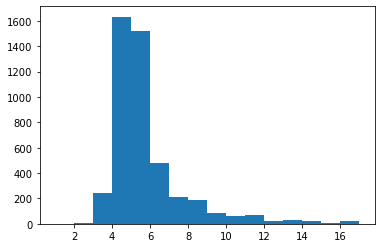

In [118]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

In [119]:
iters = simulate_robust_filter(G, W, 5, range(N), 0.8, False)

Result 0: 5    acc: 5.0                                    
Result 1: 5    acc: 5.0                                    
Result 2: 4    acc: 4.666666666666667                      
Result 3: 4    acc: 4.5                                    
Result 4: 6    acc: 4.8                                    
Result 5: 5    acc: 4.833333333333333                      
Result 6: 4    acc: 4.714285714285714                      
Result 7: 4    acc: 4.625                                  
Result 8: 4    acc: 4.555555555555555                      
Result 9: 4    acc: 4.5                                    
Result 10: 4    acc: 4.454545454545454                     
Result 11: 6    acc: 4.583333333333333                     
Result 12: 6    acc: 4.6923076923076925                    
Result 13: 5    acc: 4.714285714285714                     
Result 14: 3    acc: 4.6                                   
Result 15: 3    acc: 4.5                                   
Result 16: 3    acc: 4.411764705882353  

Result 137: 4    acc: 6.463768115942029                    
Result 138: 7    acc: 6.467625899280575                    
Result 139: 7    acc: 6.4714285714285715                   
Result 140: 8    acc: 6.4822695035460995                   
Result 141: 8    acc: 6.492957746478873                    
Result 142: 8    acc: 6.503496503496503                    
Result 143: 4    acc: 6.486111111111111                    
Result 144: 7    acc: 6.489655172413793                    
Result 145: 7    acc: 6.493150684931507                    
Result 146: 7    acc: 6.496598639455782                    
Result 147: 8    acc: 6.506756756756757                    
Result 148: 8    acc: 6.516778523489933                    
Result 149: 8    acc: 6.526666666666666                    
Result 150: 8    acc: 6.5364238410596025                   
Result 151: 7    acc: 6.5394736842105265                   
Result 152: 8    acc: 6.549019607843137                    
Result 153: 8    acc: 6.558441558441558 

Result 274: 16    acc: 5.9781818181818185                  
Result 275: 16    acc: 6.0144927536231885                  
Result 276: 17    acc: 6.054151624548736                   
Result 277: 17    acc: 6.093525179856115                   
Result 278: 13    acc: 6.118279569892473                   
Result 279: 5    acc: 6.114285714285714                    
Result 280: 4    acc: 6.106761565836299                    
Result 281: 4    acc: 6.099290780141844                    
Result 282: 4    acc: 6.091872791519434                    
Result 283: 6    acc: 6.091549295774648                    
Result 284: 4    acc: 6.08421052631579                     
Result 285: 5    acc: 6.080419580419581                    
Result 286: 4    acc: 6.073170731707317                    
Result 287: 7    acc: 6.076388888888889                    
Result 288: 6    acc: 6.076124567474048                    
Result 289: 6    acc: 6.075862068965518                    
Result 290: 4    acc: 6.0687285223367695

Result 547: 4    acc: 5.855839416058394                    
Result 548: 5    acc: 5.854280510018215                    
Result 549: 4    acc: 5.850909090909091                    
Result 550: 5    acc: 5.849364791288567                    
Result 551: 5    acc: 5.8478260869565215                   
Result 552: 5    acc: 5.84629294755877                     
Result 553: 5    acc: 5.844765342960288                    
Result 554: 5    acc: 5.8432432432432435                   
Result 555: 5    acc: 5.841726618705036                    
Result 556: 5    acc: 5.840215439856373                    
Result 557: 5    acc: 5.838709677419355                    
Result 558: 5    acc: 5.837209302325581                    
Result 559: 5    acc: 5.835714285714285                    
Result 560: 5    acc: 5.834224598930481                    
Result 561: 5    acc: 5.832740213523132                    
Result 562: 5    acc: 5.8312611012433395                   
Result 563: 4    acc: 5.828014184397163 

Result 685: 4    acc: 5.654518950437318                    
Result 686: 4    acc: 5.652110625909753                    
Result 687: 4    acc: 5.649709302325581                    
Result 688: 4    acc: 5.647314949201742                    
Result 689: 4    acc: 5.644927536231884                    
Result 690: 4    acc: 5.642547033285094                    
Result 691: 4    acc: 5.640173410404624                    
Result 692: 4    acc: 5.637806637806638                    
Result 693: 4    acc: 5.6354466858789625                   
Result 694: 4    acc: 5.633093525179856                    
Result 695: 4    acc: 5.630747126436781                    
Result 696: 4    acc: 5.628407460545193                    
Result 697: 4    acc: 5.626074498567335                    
Result 698: 4    acc: 5.623748211731044                    
Result 699: 4    acc: 5.621428571428571                    
Result 700: 4    acc: 5.619115549215406                    
Result 701: 4    acc: 5.616809116809117 

Result 822: 10    acc: 5.534629404617254                   
Result 823: 3    acc: 5.531553398058253                    
Result 824: 3    acc: 5.528484848484848                    
Result 825: 5    acc: 5.527845036319612                    
Result 826: 4    acc: 5.525997581620314                    
Result 827: 5    acc: 5.52536231884058                     
Result 828: 4    acc: 5.523522316043426                    
Result 829: 6    acc: 5.524096385542169                    
Result 830: 4    acc: 5.522262334536703                    
Result 831: 4    acc: 5.5204326923076925                   
Result 832: 4    acc: 5.518607442977191                    
Result 833: 4    acc: 5.516786570743405                    
Result 834: 4    acc: 5.514970059880239                    
Result 835: 4    acc: 5.5131578947368425                   
Result 836: 4    acc: 5.511350059737157                    
Result 837: 4    acc: 5.509546539379475                    
Result 838: 4    acc: 5.507747318235995 

Result 1095: 4    acc: 5.429744525547445                   
Result 1096: 4    acc: 5.428441203281677                   
Result 1097: 4    acc: 5.427140255009108                   
Result 1098: 4    acc: 5.425841674249318                   
Result 1099: 4    acc: 5.424545454545455                   
Result 1100: 4    acc: 5.423251589464123                   
Result 1101: 6    acc: 5.423774954627949                   
Result 1102: 3    acc: 5.42157751586582                    
Result 1103: 8    acc: 5.423913043478261                   
Result 1104: 15    acc: 5.432579185520362                  
Result 1105: 4    acc: 5.43128390596745                    
Result 1106: 4    acc: 5.429990966576333                   
Result 1107: 5    acc: 5.4296028880866425                  
Result 1108: 5    acc: 5.429215509467989                   
Result 1109: 4    acc: 5.427927927927928                   
Result 1110: 4    acc: 5.426642664266427                   
Result 1111: 4    acc: 5.425359712230215

Result 1233: 4    acc: 5.351701782820097                   
Result 1234: 4    acc: 5.350607287449392                   
Result 1235: 4    acc: 5.349514563106796                   
Result 1236: 4    acc: 5.348423605497171                   
Result 1237: 4    acc: 5.347334410339257                   
Result 1238: 4    acc: 5.346246973365617                   
Result 1239: 4    acc: 5.34516129032258                    
Result 1240: 4    acc: 5.344077356970185                   
Result 1241: 5    acc: 5.343800322061192                   
Result 1242: 4    acc: 5.34271922767498                    
Result 1243: 4    acc: 5.341639871382637                   
Result 1244: 5    acc: 5.341365461847389                   
Result 1245: 4    acc: 5.340288924558587                   
Result 1246: 4    acc: 5.339214113873296                   
Result 1247: 4    acc: 5.3381410256410255                  
Result 1248: 5    acc: 5.337870296236989                   
Result 1249: 5    acc: 5.3376           

Result 1370: 5    acc: 5.261123267687819                   
Result 1371: 5    acc: 5.260932944606414                   
Result 1372: 5    acc: 5.260742898761835                   
Result 1373: 5    acc: 5.260553129548763                   
Result 1374: 5    acc: 5.260363636363636                   
Result 1375: 5    acc: 5.2601744186046515                  
Result 1376: 5    acc: 5.25998547567175                    
Result 1377: 5    acc: 5.2597968069666186                  
Result 1378: 5    acc: 5.259608411892676                   
Result 1379: 5    acc: 5.259420289855073                   
Result 1380: 5    acc: 5.25923244026068                    
Result 1381: 5    acc: 5.25904486251809                    
Result 1382: 5    acc: 5.2588575560376                     
Result 1383: 5    acc: 5.258670520231214                   
Result 1384: 5    acc: 5.2584837545126355                  
Result 1385: 5    acc: 5.258297258297258                   
Result 1386: 5    acc: 5.258111031002163

Result 1508: 5    acc: 5.24519549370444                    
Result 1509: 5    acc: 5.245033112582782                   
Result 1510: 4    acc: 5.244209133024487                   
Result 1511: 3    acc: 5.242724867724868                   
Result 1512: 4    acc: 5.241903502974224                   
Result 1513: 4    acc: 5.24108322324967                    
Result 1514: 4    acc: 5.24026402640264                    
Result 1515: 4    acc: 5.239445910290238                   
Result 1516: 5    acc: 5.239288068556362                   
Result 1517: 4    acc: 5.238471673254282                   
Result 1518: 4    acc: 5.237656352863726                   
Result 1519: 4    acc: 5.2368421052631575                  
Result 1520: 4    acc: 5.236028928336621                   
Result 1521: 4    acc: 5.235216819973719                   
Result 1522: 4    acc: 5.2344057780696                     
Result 1523: 4    acc: 5.233595800524935                   
Result 1524: 4    acc: 5.232786885245901

Result 1781: 4    acc: 5.179012345679013                   
Result 1782: 5    acc: 5.17891194615816                    
Result 1783: 5    acc: 5.178811659192825                   
Result 1784: 5    acc: 5.178711484593838                   
Result 1785: 5    acc: 5.178611422172453                   
Result 1786: 5    acc: 5.178511471740347                   
Result 1787: 5    acc: 5.1784116331096195                  
Result 1788: 5    acc: 5.178311906092789                   
Result 1789: 4    acc: 5.177653631284916                   
Result 1790: 4    acc: 5.176996091568956                   
Result 1791: 4    acc: 5.176339285714286                   
Result 1792: 4    acc: 5.175683212493029                   
Result 1793: 4    acc: 5.1750278706800446                  
Result 1794: 8    acc: 5.176601671309192                   
Result 1795: 6    acc: 5.17706013363029                    
Result 1796: 3    acc: 5.175848636616583                   
Result 1797: 4    acc: 5.175194660734149

Result 2054: 5    acc: 5.151824817518248                   
Result 2055: 15    acc: 5.156614785992218                  
Result 2056: 3    acc: 5.155566358774915                   
Result 2057: 6    acc: 5.15597667638484                    
Result 2058: 4    acc: 5.155415250121418                   
Result 2059: 4    acc: 5.154854368932039                   
Result 2060: 4    acc: 5.15429403202329                    
Result 2061: 4    acc: 5.153734238603298                   
Result 2062: 5    acc: 5.1536597188560345                  
Result 2063: 5    acc: 5.153585271317829                   
Result 2064: 5    acc: 5.153510895883778                   
Result 2065: 5    acc: 5.153436592449177                   
Result 2066: 5    acc: 5.153362360909531                   
Result 2067: 5    acc: 5.153288201160541                   
Result 2068: 5    acc: 5.153214113098115                   
Result 2069: 6    acc: 5.153623188405797                   
Result 2070: 5    acc: 5.153549010140029

Result 2326: 5    acc: 5.094112591319295                   
Result 2327: 5    acc: 5.094072164948454                   
Result 2328: 5    acc: 5.094031773293259                   
Result 2329: 5    acc: 5.093991416309013                   
Result 2330: 5    acc: 5.093951093951094                   
Result 2331: 5    acc: 5.093910806174957                   
Result 2332: 5    acc: 5.093870552936134                   
Result 2333: 4    acc: 5.093401885175664                   
Result 2334: 5    acc: 5.093361884368308                   
Result 2335: 5    acc: 5.093321917808219                   
Result 2336: 4    acc: 5.092854086435601                   
Result 2337: 4    acc: 5.092386655260907                   
Result 2338: 4    acc: 5.091919623770842                   
Result 2339: 4    acc: 5.091452991452991                   
Result 2340: 4    acc: 5.090986757795814                   
Result 2341: 4    acc: 5.0905209222886425                  
Result 2342: 4    acc: 5.090055484421682

Result 2463: 6    acc: 5.122159090909091                   
Result 2464: 4    acc: 5.121703853955375                   
Result 2465: 4    acc: 5.12124898621249                    
Result 2466: 4    acc: 5.120794487231455                   
Result 2467: 4    acc: 5.12034035656402                    
Result 2468: 4    acc: 5.119886593762657                   
Result 2469: 4    acc: 5.119433198380567                   
Result 2470: 4    acc: 5.118980169971671                   
Result 2471: 4    acc: 5.118527508090615                   
Result 2472: 4    acc: 5.118075212292762                   
Result 2473: 4    acc: 5.117623282134196                   
Result 2474: 4    acc: 5.1171717171717175                  
Result 2475: 4    acc: 5.116720516962843                   
Result 2476: 4    acc: 5.1162696810658055                  
Result 2477: 4    acc: 5.1158192090395485                  
Result 2478: 4    acc: 5.115369100443727                   
Result 2479: 4    acc: 5.11491935483871 

Result 2736: 4    acc: 5.154914139568871                   
Result 2737: 4    acc: 5.154492330168006                   
Result 2738: 4    acc: 5.1540708287696235                  
Result 2739: 4    acc: 5.153649635036496                   
Result 2740: 4    acc: 5.153228748631886                   
Result 2741: 5    acc: 5.153172866520788                   
Result 2742: 5    acc: 5.153117025154939                   
Result 2743: 4    acc: 5.1526967930029155                  
Result 2744: 9    acc: 5.154098360655738                   
Result 2745: 3    acc: 5.153313911143481                   
Result 2746: 4    acc: 5.152894066254095                   
Result 2747: 4    acc: 5.152474526928676                   
Result 2748: 5    acc: 5.152419061476901                   
Result 2749: 5    acc: 5.152363636363637                   
Result 2750: 5    acc: 5.152308251544893                   
Result 2751: 5    acc: 5.152252906976744                   
Result 2752: 9    acc: 5.153650563022158

Result 2875: 4    acc: 5.2103616133518775                  
Result 2876: 4    acc: 5.209940910670838                   
Result 2877: 4    acc: 5.209520500347463                   
Result 2878: 4    acc: 5.20910038207711                    
Result 2879: 8    acc: 5.210069444444445                   
Result 2880: 8    acc: 5.211037834085387                   
Result 2881: 8    acc: 5.212005551700209                   
Result 2882: 8    acc: 5.212972597988207                   
Result 2883: 8    acc: 5.2139389736477115                  
Result 2884: 8    acc: 5.214904679376083                   
Result 2885: 8    acc: 5.215869715869716                   
Result 2886: 8    acc: 5.216834083824039                   
Result 2887: 8    acc: 5.217797783933518                   
Result 2888: 8    acc: 5.218760816891658                   
Result 2889: 8    acc: 5.219723183391004                   
Result 2890: 8    acc: 5.22068488412314                    
Result 2891: 8    acc: 5.2216459197787  

Result 3014: 3    acc: 5.197014925373134                   
Result 3015: 3    acc: 5.196286472148541                   
Result 3016: 4    acc: 5.195889956910839                   
Result 3017: 5    acc: 5.1958250497017895                  
Result 3018: 5    acc: 5.195760185491885                   
Result 3019: 5    acc: 5.195695364238411                   
Result 3020: 5    acc: 5.195630585898709                   
Result 3021: 5    acc: 5.195565850430179                   
Result 3022: 5    acc: 5.195501157790274                   
Result 3023: 5    acc: 5.195436507936508                   
Result 3024: 5    acc: 5.195371900826446                   
Result 3025: 5    acc: 5.195307336417713                   
Result 3026: 5    acc: 5.1952428146679885                  
Result 3027: 5    acc: 5.195178335535006                   
Result 3028: 5    acc: 5.19511389897656                    
Result 3029: 5    acc: 5.195049504950495                   
Result 3030: 5    acc: 5.194985153414715

Result 3286: 7    acc: 5.3510800121691515                  
Result 3287: 7    acc: 5.351581508515815                   
Result 3288: 7    acc: 5.352082699908787                   
Result 3289: 5    acc: 5.351975683890577                   
Result 3290: 7    acc: 5.35247645092677                    
Result 3291: 5    acc: 5.352369380315918                   
Result 3292: 7    acc: 5.352869723656241                   
Result 3293: 5    acc: 5.352762598664238                   
Result 3294: 6    acc: 5.352959028831563                   
Result 3295: 6    acc: 5.353155339805825                   
Result 3296: 7    acc: 5.353654837731271                   
Result 3297: 7    acc: 5.354154032747119                   
Result 3298: 7    acc: 5.354652925128827                   
Result 3299: 7    acc: 5.355151515151515                   
Result 3300: 6    acc: 5.355346864586489                   
Result 3301: 6    acc: 5.355542095699576                   
Result 3302: 6    acc: 5.355737208598244

Result 3561: 4    acc: 5.47164514317799                    
Result 3562: 4    acc: 5.471232107774347                   
Result 3563: 9    acc: 5.472222222222222                   
Result 3564: 9    acc: 5.473211781206171                   
Result 3565: 9    acc: 5.474200785193494                   
Result 3566: 17    acc: 5.477432015699467                  
Result 3567: 17    acc: 5.480661434977579                  
Result 3568: 17    acc: 5.483889044550295                  
Result 3569: 13    acc: 5.485994397759104                  
Result 3570: 13    acc: 5.488098571828619                  
Result 3571: 13    acc: 5.4902015677491605                 
Result 3572: 13    acc: 5.492303386509936                  
Result 3573: 13    acc: 5.494404029099049                  
Result 3574: 13    acc: 5.496503496503497                  
Result 3575: 15    acc: 5.499161073825503                  
Result 3576: 15    acc: 5.501817165222254                  
Result 3577: 14    acc: 5.50419228619340

Result 3833: 4    acc: 5.552164840897235                   
Result 3834: 4    acc: 5.551760104302478                   
Result 3835: 5    acc: 5.551616266944734                   
Result 3836: 5    acc: 5.551472504560855                   
Result 3837: 5    acc: 5.5513288170922355                  
Result 3838: 5    acc: 5.551185204480333                   
Result 3839: 5    acc: 5.551041666666666                   
Result 3840: 5    acc: 5.550898203592815                   
Result 3841: 5    acc: 5.550754815200416                   
Result 3842: 4    acc: 5.5503512880562065                  
Result 3843: 8    acc: 5.5509885535900105                  
Result 3844: 4    acc: 5.550585175552666                   
Result 3845: 4    acc: 5.550182007280291                   
Result 3846: 4    acc: 5.549779048609306                   
Result 3847: 4    acc: 5.549376299376299                   
Result 3848: 5    acc: 5.549233567160301                   
Result 3849: 4    acc: 5.548831168831168

Result 3970: 4    acc: 5.583983883152858                   
Result 3971: 8    acc: 5.5845921450151055                  
Result 3972: 8    acc: 5.585200100679587                   
Result 3973: 8    acc: 5.5858077503774535                  
Result 3974: 8    acc: 5.586415094339623                   
Result 3975: 8    acc: 5.587022132796781                   
Result 3976: 8    acc: 5.587628865979381                   
Result 3977: 11    acc: 5.588989441930618                  
Result 3978: 11    acc: 5.590349334003519                  
Result 3979: 5    acc: 5.590201005025126                   
Result 3980: 4    acc: 5.589801557397639                   
Result 3981: 4    acc: 5.589402310396785                   
Result 3982: 4    acc: 5.5890032638714535                  
Result 3983: 5    acc: 5.588855421686747                   
Result 3984: 4    acc: 5.588456712672522                   
Result 3985: 4    acc: 5.588058203712995                   
Result 3986: 5    acc: 5.587910709806873

Result 4243: 12    acc: 5.551366635249765                  
Result 4244: 12    acc: 5.552885747938752                  
Result 4245: 18    acc: 5.555817239755064                  
Result 4246: 12    acc: 5.557334589121733                  
Result 4247: 11    acc: 5.55861581920904                   
Result 4248: 11    acc: 5.55989644622264                   
Result 4249: 6    acc: 5.56                                
Result 4250: 9    acc: 5.56080922135968                    
Result 4251: 4    acc: 5.560442144873001                   
Result 4252: 5    acc: 5.560310369151187                   
Result 4253: 4    acc: 5.559943582510578                   
Result 4254: 5    acc: 5.559811985898943                   
Result 4255: 4    acc: 5.5594454887218046                  
Result 4256: 4    acc: 5.559079163730327                   
Result 4257: 5    acc: 5.558947862846407                   
Result 4258: 5    acc: 5.558816623620568                   
Result 4259: 4    acc: 5.558450704225352

Result 4381: 4    acc: 5.591510725696029                   
Result 4382: 4    acc: 5.591147615788273                   
Result 4383: 5    acc: 5.591012773722627                   
Result 4384: 6    acc: 5.591106043329533                   
Result 4385: 6    acc: 5.591199270405837                   
Result 4386: 6    acc: 5.591292454980625                   
Result 4387: 6    acc: 5.591385597082954                   
Result 4388: 6    acc: 5.591478696741855                   
Result 4389: 5    acc: 5.5913439635535305                  
Result 4390: 5    acc: 5.59120929173309                    
Result 4391: 5    acc: 5.591074681238616                   
Result 4392: 5    acc: 5.590940132028226                   
Result 4393: 5    acc: 5.590805644060082                   
Result 4394: 5    acc: 5.590671217292377                   
Result 4395: 5    acc: 5.590536851683349                   
Result 4396: 5    acc: 5.590402547191267                   
Result 4397: 4    acc: 5.590040927694407

Result 4519: 7    acc: 5.573672566371681                   
Result 4520: 7    acc: 5.57398805573988                    
Result 4521: 7    acc: 5.574303405572755                   
Result 4522: 7    acc: 5.574618615962857                   
Result 4523: 7    acc: 5.574933687002653                   
Result 4524: 7    acc: 5.5752486187845305                  
Result 4525: 7    acc: 5.575563411400795                   
Result 4526: 7    acc: 5.575878064943671                   
Result 4527: 7    acc: 5.5761925795053005                  
Result 4528: 7    acc: 5.576506955177743                   
Result 4529: 7    acc: 5.57682119205298                    
Result 4530: 7    acc: 5.577135290222909                   
Result 4531: 7    acc: 5.577449249779347                   
Result 4532: 7    acc: 5.57776307081403                    
Result 4533: 7    acc: 5.578076753418615                   
Result 4534: 7    acc: 5.578390297684675                   
Result 4535: 7    acc: 5.578703703703703

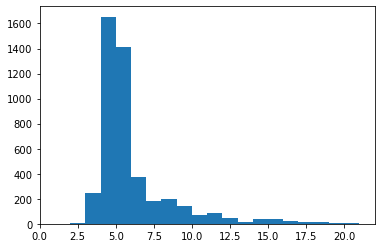

In [120]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

In [121]:
iters = simulate_robust_filter(G, W, 5, range(N), 1, False)

Result 0: 4    acc: 4.0                                    
Result 1: 4    acc: 4.0                                    
Result 2: 3    acc: 3.6666666666666665                     
Result 3: 3    acc: 3.5                                    
Result 4: 7    acc: 4.2                                    
Result 5: 8    acc: 4.833333333333333                      
Result 6: 4    acc: 4.714285714285714                      
Result 7: 4    acc: 4.625                                  
Result 8: 4    acc: 4.555555555555555                      
Result 9: 4    acc: 4.5                                    
Result 10: 4    acc: 4.454545454545454                     
Result 11: 7    acc: 4.666666666666667                     
Result 12: 7    acc: 4.846153846153846                     
Result 13: 4    acc: 4.785714285714286                     
Result 14: 4    acc: 4.733333333333333                     
Result 15: 4    acc: 4.6875                                
Result 16: 4    acc: 4.647058823529412  

Result 137: 4    acc: 6.521739130434782                    
Result 138: 8    acc: 6.532374100719425                    
Result 139: 9    acc: 6.55                                 
Result 140: 9    acc: 6.567375886524823                    
Result 141: 9    acc: 6.584507042253521                    
Result 142: 9    acc: 6.601398601398602                    
Result 143: 4    acc: 6.583333333333333                    
Result 144: 7    acc: 6.586206896551724                    
Result 145: 7    acc: 6.589041095890411                    
Result 146: 7    acc: 6.591836734693878                    
Result 147: 9    acc: 6.608108108108108                    
Result 148: 9    acc: 6.624161073825503                    
Result 149: 9    acc: 6.64                                 
Result 150: 9    acc: 6.655629139072848                    
Result 151: 9    acc: 6.671052631578948                    
Result 152: 8    acc: 6.6797385620915035                   
Result 153: 9    acc: 6.694805194805195 

Result 274: 22    acc: 6.567272727272727                   
Result 275: 22    acc: 6.6231884057971016                  
Result 276: 22    acc: 6.67870036101083                    
Result 277: 22    acc: 6.733812949640288                   
Result 278: 18    acc: 6.774193548387097                   
Result 279: 4    acc: 6.764285714285714                    
Result 280: 4    acc: 6.754448398576512                    
Result 281: 4    acc: 6.74468085106383                     
Result 282: 5    acc: 6.738515901060071                    
Result 283: 10    acc: 6.75                                
Result 284: 4    acc: 6.7403508771929825                   
Result 285: 4    acc: 6.730769230769231                    
Result 286: 22    acc: 6.7839721254355405                  
Result 287: 5    acc: 6.777777777777778                    
Result 288: 8    acc: 6.782006920415225                    
Result 289: 10    acc: 6.793103448275862                   
Result 290: 25    acc: 6.855670103092783

Result 546: 11    acc: 7.422303473491773                   
Result 547: 3    acc: 7.414233576642336                    
Result 548: 4    acc: 7.408014571948998                    
Result 549: 8    acc: 7.409090909090909                    
Result 550: 4    acc: 7.402903811252268                    
Result 551: 4    acc: 7.396739130434782                    
Result 552: 4    acc: 7.390596745027125                    
Result 553: 4    acc: 7.384476534296029                    
Result 554: 4    acc: 7.378378378378378                    
Result 555: 4    acc: 7.372302158273381                    
Result 556: 4    acc: 7.36624775583483                     
Result 557: 4    acc: 7.360215053763441                    
Result 558: 4    acc: 7.354203935599284                    
Result 559: 4    acc: 7.348214285714286                    
Result 560: 4    acc: 7.342245989304812                    
Result 561: 4    acc: 7.3362989323843415                   
Result 562: 4    acc: 7.3303730017761985

Result 683: 5    acc: 7.0964912280701755                   
Result 684: 3    acc: 7.090510948905109                    
Result 685: 8    acc: 7.091836734693878                    
Result 686: 8    acc: 7.09315866084425                     
Result 687: 8    acc: 7.094476744186046                    
Result 688: 7    acc: 7.09433962264151                     
Result 689: 8    acc: 7.095652173913043                    
Result 690: 8    acc: 7.096960926193922                    
Result 691: 8    acc: 7.098265895953757                    
Result 692: 8    acc: 7.0995670995671                      
Result 693: 8    acc: 7.100864553314121                    
Result 694: 8    acc: 7.102158273381295                    
Result 695: 8    acc: 7.103448275862069                    
Result 696: 8    acc: 7.104734576757532                    
Result 697: 8    acc: 7.106017191977077                    
Result 698: 5    acc: 7.103004291845494                    
Result 699: 8    acc: 7.104285714285714 

Result 821: 3    acc: 7.135036496350365                    
Result 822: 13    acc: 7.142162818955042                   
Result 823: 5    acc: 7.139563106796117                    
Result 824: 5    acc: 7.136969696969697                    
Result 825: 4    acc: 7.13317191283293                     
Result 826: 3    acc: 7.128174123337364                    
Result 827: 4    acc: 7.124396135265701                    
Result 828: 8    acc: 7.125452352231604                    
Result 829: 11    acc: 7.130120481927711                   
Result 830: 4    acc: 7.126353790613718                    
Result 831: 4    acc: 7.122596153846154                    
Result 832: 5    acc: 7.120048019207683                    
Result 833: 5    acc: 7.117505995203837                    
Result 834: 5    acc: 7.11497005988024                     
Result 835: 5    acc: 7.1124401913875595                   
Result 836: 5    acc: 7.109916367980884                    
Result 837: 5    acc: 7.107398568019093 

Result 959: 5    acc: 7.275                                
Result 960: 5    acc: 7.272632674297607                    
Result 961: 4    acc: 7.269230769230769                    
Result 962: 5    acc: 7.266874350986501                    
Result 963: 25    acc: 7.285269709543568                   
Result 964: 5    acc: 7.282901554404145                    
Result 965: 5    acc: 7.280538302277432                    
Result 966: 5    acc: 7.27817993795243                     
Result 967: 5    acc: 7.275826446280992                    
Result 968: 5    acc: 7.273477812177503                    
Result 969: 23    acc: 7.289690721649484                   
Result 970: 11    acc: 7.29351184346035                    
Result 971: 11    acc: 7.2973251028806585                  
Result 972: 8    acc: 7.298047276464542                    
Result 973: 8    acc: 7.298767967145791                    
Result 974: 8    acc: 7.29948717948718                     
Result 975: 9    acc: 7.301229508196721 

Result 1096: 4    acc: 7.228805834092981                   
Result 1097: 4    acc: 7.225865209471767                   
Result 1098: 4    acc: 7.222929936305732                   
Result 1099: 4    acc: 7.22                                
Result 1100: 4    acc: 7.2170753860127155                  
Result 1101: 24    acc: 7.2323049001814885                 
Result 1102: 25    acc: 7.248413417951043                  
Result 1103: 4    acc: 7.245471014492754                   
Result 1104: 17    acc: 7.254298642533937                  
Result 1105: 4    acc: 7.251356238698011                   
Result 1106: 20    acc: 7.262872628726288                  
Result 1107: 6    acc: 7.26173285198556                    
Result 1108: 5    acc: 7.259693417493237                   
Result 1109: 4    acc: 7.256756756756757                   
Result 1110: 4    acc: 7.2538253825382535                  
Result 1111: 4    acc: 7.250899280575539                   
Result 1112: 14    acc: 7.25696316262354

Result 1369: 5    acc: 6.964963503649635                   
Result 1370: 5    acc: 6.963530269876003                   
Result 1371: 5    acc: 6.962099125364431                   
Result 1372: 5    acc: 6.96067006554989                    
Result 1373: 5    acc: 6.95924308588064                    
Result 1374: 4    acc: 6.957090909090909                   
Result 1375: 4    acc: 6.954941860465116                   
Result 1376: 5    acc: 6.953522149600581                   
Result 1377: 4    acc: 6.951378809869376                   
Result 1378: 4    acc: 6.949238578680203                   
Result 1379: 4    acc: 6.947101449275363                   
Result 1380: 4    acc: 6.944967414916727                   
Result 1381: 5    acc: 6.94356005788712                    
Result 1382: 5    acc: 6.942154736080983                   
Result 1383: 5    acc: 6.940751445086705                   
Result 1384: 5    acc: 6.939350180505415                   
Result 1385: 5    acc: 6.937950937950938

Result 1642: 4    acc: 6.962264150943396                   
Result 1643: 8    acc: 6.9628953771289535                  
Result 1644: 8    acc: 6.963525835866261                   
Result 1645: 8    acc: 6.964155528554071                   
Result 1646: 5    acc: 6.962962962962963                   
Result 1647: 4    acc: 6.961165048543689                   
Result 1648: 4    acc: 6.959369314736204                   
Result 1649: 4    acc: 6.957575757575758                   
Result 1650: 5    acc: 6.9563900666262874                  
Result 1651: 5    acc: 6.955205811138015                   
Result 1652: 5    acc: 6.954022988505747                   
Result 1653: 5    acc: 6.952841596130592                   
Result 1654: 5    acc: 6.95166163141994                    
Result 1655: 5    acc: 6.950483091787439                   
Result 1656: 5    acc: 6.9493059746529875                  
Result 1657: 5    acc: 6.948130277442702                   
Result 1658: 5    acc: 6.946955997588909

Result 1915: 5    acc: 7.017223382045929                   
Result 1916: 4    acc: 7.01564945226917                    
Result 1917: 4    acc: 7.014077163712201                   
Result 1918: 4    acc: 7.012506513809275                   
Result 1919: 5    acc: 7.011458333333334                   
Result 1920: 5    acc: 7.0104112441436754                  
Result 1921: 5    acc: 7.009365244536941                   
Result 1922: 5    acc: 7.008320332813312                   
Result 1923: 5    acc: 7.007276507276507                   
Result 1924: 5    acc: 7.006233766233766                   
Result 1925: 5    acc: 7.005192107995846                   
Result 1926: 5    acc: 7.004151530877011                   
Result 1927: 5    acc: 7.003112033195021                   
Result 1928: 5    acc: 7.002073613271125                   
Result 1929: 5    acc: 7.001036269430052                   
Result 1930: 5    acc: 7.0                                 
Result 1931: 5    acc: 6.99896480331263 

Result 2052: 4    acc: 6.928397467121286                   
Result 2053: 4    acc: 6.926971762414801                   
Result 2054: 8    acc: 6.927493917274939                   
Result 2055: 28    acc: 6.937743190661479                  
Result 2056: 2    acc: 6.935342732134176                   
Result 2057: 9    acc: 6.9363459669582115                  
Result 2058: 10    acc: 6.937833899951433                  
Result 2059: 10    acc: 6.939320388349515                  
Result 2060: 9    acc: 6.940320232896652                   
Result 2061: 9    acc: 6.941319107662464                   
Result 2062: 4    acc: 6.9398933591856515                  
Result 2063: 4    acc: 6.938468992248062                   
Result 2064: 4    acc: 6.937046004842615                   
Result 2065: 4    acc: 6.935624394966118                   
Result 2066: 4    acc: 6.934204160619255                   
Result 2067: 4    acc: 6.932785299806576                   
Result 2068: 4    acc: 6.931367810536491

Result 2324: 4    acc: 6.9561290322580644                  
Result 2325: 4    acc: 6.954858125537403                   
Result 2326: 4    acc: 6.95358831113021                    
Result 2327: 4    acc: 6.952319587628866                   
Result 2328: 4    acc: 6.951051953628166                   
Result 2329: 4    acc: 6.949785407725322                   
Result 2330: 4    acc: 6.948519948519949                   
Result 2331: 4    acc: 6.947255574614065                   
Result 2332: 4    acc: 6.945992284612087                   
Result 2333: 4    acc: 6.9447300771208225                  
Result 2334: 4    acc: 6.943468950749464                   
Result 2335: 4    acc: 6.942208904109589                   
Result 2336: 4    acc: 6.940949935815148                   
Result 2337: 4    acc: 6.939692044482464                   
Result 2338: 7    acc: 6.9397178281316805                  
Result 2339: 7    acc: 6.93974358974359                    
Result 2340: 7    acc: 6.939769329346433

Result 2597: 5    acc: 6.968052347959969                   
Result 2598: 5    acc: 6.967295113505195                   
Result 2599: 4    acc: 6.966153846153846                   
Result 2600: 4    acc: 6.965013456362938                   
Result 2601: 4    acc: 6.963873943120676                   
Result 2602: 8    acc: 6.964271993853246                   
Result 2603: 8    acc: 6.964669738863288                   
Result 2604: 5    acc: 6.963915547024952                   
Result 2605: 5    acc: 6.963161933998465                   
Result 2606: 9    acc: 6.963943229766015                   
Result 2607: 9    acc: 6.964723926380368                   
Result 2608: 9    acc: 6.965504024530471                   
Result 2609: 5    acc: 6.964750957854406                   
Result 2610: 5    acc: 6.963998468019915                   
Result 2611: 5    acc: 6.9632465543644715                  
Result 2612: 8    acc: 6.963643321852277                   
Result 2613: 10    acc: 6.96480489671002

Result 2869: 4    acc: 7.108710801393729                   
Result 2870: 4    acc: 7.107628004179729                   
Result 2871: 4    acc: 7.1065459610027855                  
Result 2872: 4    acc: 7.105464671075531                   
Result 2873: 4    acc: 7.104384133611691                   
Result 2874: 4    acc: 7.103304347826087                   
Result 2875: 7    acc: 7.10326842837274                    
Result 2876: 7    acc: 7.103232533889468                   
Result 2877: 7    acc: 7.103196664350243                   
Result 2878: 7    acc: 7.103160819729073                   
Result 2879: 3    acc: 7.101736111111111                   
Result 2880: 3    acc: 7.100312391530719                   
Result 2881: 3    acc: 7.098889659958362                   
Result 2882: 3    acc: 7.097467915365939                   
Result 2883: 3    acc: 7.096047156726768                   
Result 2884: 8    acc: 7.096360485268631                   
Result 2885: 8    acc: 7.096673596673597

Result 3006: 7    acc: 7.011972065181244                   
Result 3007: 7    acc: 7.011968085106383                   
Result 3008: 7    acc: 7.011964107676969                   
Result 3009: 7    acc: 7.011960132890366                   
Result 3010: 7    acc: 7.011956160743939                   
Result 3011: 7    acc: 7.01195219123506                    
Result 3012: 4    acc: 7.010952538997676                   
Result 3013: 4    acc: 7.009953550099535                   
Result 3014: 4    acc: 7.008955223880597                   
Result 3015: 4    acc: 7.007957559681698                   
Result 3016: 7    acc: 7.007954922108055                   
Result 3017: 7    acc: 7.007952286282306                   
Result 3018: 7    acc: 7.007949652202716                   
Result 3019: 7    acc: 7.00794701986755                    
Result 3020: 7    acc: 7.007944389275075                   
Result 3021: 7    acc: 7.00794176042356                    
Result 3022: 7    acc: 7.007939133311281

Result 3278: 15    acc: 7.281488258615432                  
Result 3279: 29    acc: 7.288109756097561                  
Result 3280: 4    acc: 7.28710758914965                    
Result 3281: 15    acc: 7.2894576477757465                 
Result 3282: 15    acc: 7.291806274748706                  
Result 3283: 15    acc: 7.2941534713763705                 
Result 3284: 15    acc: 7.2964992389649925                 
Result 3285: 16    acc: 7.299147900182593                  
Result 3286: 16    acc: 7.301794949802251                  
Result 3287: 15    acc: 7.304136253041363                  
Result 3288: 15    acc: 7.306476132563089                  
Result 3289: 16    acc: 7.309118541033435                  
Result 3290: 17    acc: 7.31206320267396                   
Result 3291: 16    acc: 7.314702308626974                  
Result 3292: 28    acc: 7.320983905253568                  
Result 3293: 16    acc: 7.323618700667881                  
Result 3294: 28    acc: 7.32989377845220

Result 3550: 10    acc: 7.661785412559842                  
Result 3551: 10    acc: 7.662443693693693                  
Result 3552: 10    acc: 7.663101604278075                  
Result 3553: 10    acc: 7.663759144625773                  
Result 3554: 10    acc: 7.664416315049227                  
Result 3555: 10    acc: 7.665073115860517                  
Result 3556: 10    acc: 7.66572954737138                   
Result 3557: 10    acc: 7.666385609893198                  
Result 3558: 10    acc: 7.667041303737005                  
Result 3559: 5    acc: 7.666292134831461                   
Result 3560: 5    acc: 7.665543386689133                   
Result 3561: 5    acc: 7.664795058955643                   
Result 3562: 5    acc: 7.664047151277014                   
Result 3563: 12    acc: 7.665263748597082                  
Result 3564: 12    acc: 7.666479663394109                  
Result 3565: 12    acc: 7.667694896242288                  
Result 3566: 18    acc: 7.67059153350154

Result 3823: 7    acc: 7.934884937238493                   
Result 3824: 6    acc: 7.93437908496732                    
Result 3825: 6    acc: 7.933873497124934                   
Result 3826: 6    acc: 7.93336817350405                    
Result 3827: 6    acc: 7.9328631138975965                  
Result 3828: 6    acc: 7.9323583180987205                  
Result 3829: 6    acc: 7.931853785900783                   
Result 3830: 6    acc: 7.931349517097364                   
Result 3831: 6    acc: 7.9308455114822545                  
Result 3832: 6    acc: 7.930341768849465                   
Result 3833: 6    acc: 7.929838288993219                   
Result 3834: 6    acc: 7.929335071707953                   
Result 3835: 4    acc: 7.928310740354536                   
Result 3836: 4    acc: 7.92728694292416                    
Result 3837: 4    acc: 7.9262636789994785                  
Result 3838: 4    acc: 7.925240948163585                   
Result 3839: 4    acc: 7.92421875       

Result 4095: 4    acc: 8.177978515625                      
Result 4096: 4    acc: 8.1769587503051                     
Result 4097: 3    acc: 8.175695461200586                   
Result 4098: 3    acc: 8.174432788484996                   
Result 4099: 4    acc: 8.173414634146342                   
Result 4100: 4    acc: 8.172396976347232                   
Result 4101: 4    acc: 8.171379814724524                   
Result 4102: 3    acc: 8.170119424811114                   
Result 4103: 3    acc: 8.168859649122806                   
Result 4104: 4    acc: 8.167844092570036                   
Result 4105: 4    acc: 8.1668290306868                     
Result 4106: 4    acc: 8.16581446311176                    
Result 4107: 4    acc: 8.164800389483934                   
Result 4108: 4    acc: 8.163786809442687                   
Result 4109: 4    acc: 8.162773722627737                   
Result 4110: 3    acc: 8.161517878861591                   
Result 4111: 10    acc: 8.16196498054474

Result 4232: 4    acc: 8.315379163713677                   
Result 4233: 4    acc: 8.314359943316013                   
Result 4234: 4    acc: 8.313341204250294                   
Result 4235: 4    acc: 8.312322946175637                   
Result 4236: 9    acc: 8.312485248996932                   
Result 4237: 9    acc: 8.312647475224162                   
Result 4238: 9    acc: 8.312809624911536                   
Result 4239: 9    acc: 8.312971698113207                   
Result 4240: 9    acc: 8.313133694883282                   
Result 4241: 17    acc: 8.315181518151816                  
Result 4242: 4    acc: 8.31416450624558                    
Result 4243: 21    acc: 8.317153628652214                  
Result 4244: 21    acc: 8.320141342756184                  
Result 4245: 17    acc: 8.32218558643429                   
Result 4246: 10    acc: 8.32258064516129                   
Result 4247: 18    acc: 8.324858757062147                  
Result 4248: 18    acc: 8.32713579665803

Result 4504: 8    acc: 8.388235294117647                   
Result 4505: 28    acc: 8.392587660896583                  
Result 4506: 28    acc: 8.396938096294653                  
Result 4507: 27    acc: 8.40106477373558                   
Result 4508: 27    acc: 8.405189620758483                  
Result 4509: 27    acc: 8.409312638580932                  
Result 4510: 27    acc: 8.41343382841942                   
Result 4511: 27    acc: 8.417553191489361                  
Result 4512: 27    acc: 8.421670729005097                  
Result 4513: 28    acc: 8.426007975188304                  
Result 4514: 28    acc: 8.430343300110742                  
Result 4515: 28    acc: 8.434676705048716                  
Result 4516: 28    acc: 8.439008191277397                  
Result 4517: 28    acc: 8.443337760070827                  
Result 4518: 32    acc: 8.448550564284133                  
Result 4519: 33    acc: 8.453982300884956                  
Result 4520: 33    acc: 8.45941163459411

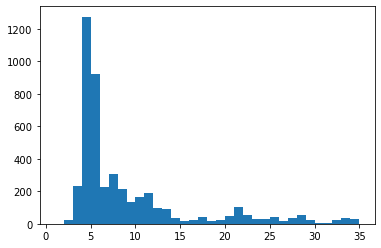

In [122]:
bins = range(1, max(iters) + 2)
plt.hist(iters, bins=bins)
plt.show()

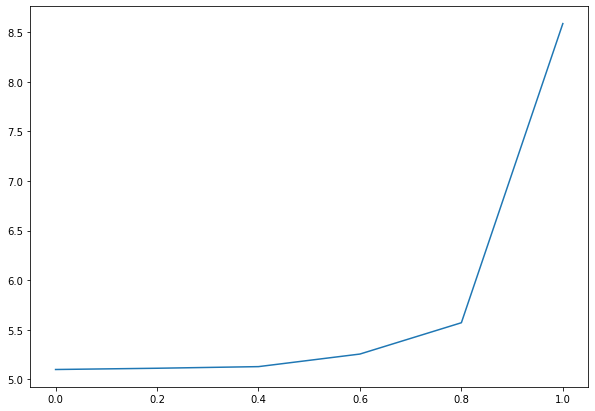

In [19]:
x = [0, 0.2, 0.4, 0.6, 0.8, 1]
y = [5.097688617531618, 5.110335804622765, 5.126689925861317, 5.253597906672481, 5.5695595290013085, 8.587658089838639]

plt.figure(figsize=(10, 7))
plt.plot(x, y)
plt.show()